In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from PyEMD import EMD, EEMD, CEEMDAN
import warnings
warnings.filterwarnings('ignore')

In [2]:
from __future__ import division

In [3]:
from matplotlib.colors import ListedColormap

In [4]:
cmap = ['magenta', 'rebeccapurple', 'turquoise','darkcyan', 'mediumslateblue','limegreen','dodgerblue']

In [5]:
pal = sns.color_palette(cmap)
sns.set_palette(pal)
box_pal = sns.color_palette(['turquoise','darkcyan'])
light_pal = sns.color_palette(['mediumslateblue','limegreen'])

### <font color = "limegreen"> Let's look at the available well log data and implement data preprocessing. </font>

In [7]:
def plot_boxplots(data):
    fig, axes = plt.subplots(data.shape[1],1)
    fig.set_figheight(13)
    fig.set_figwidth(8)
    for c in range(data.shape[1]):
        axes[c] = sns.boxplot(data = data[data.columns[c]],
                              ax = axes[c],palette = box_pal,orient='h'
                              ,fliersize=10).set_title(data[data.columns[c]].name)
    plt.tight_layout()

In [8]:
data = pd.read_csv('facies_data.csv')
data.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915
5,3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894
6,3,A1 SH,SHRIMPLIN,2796.0,73.72,0.630,15.6,13.930,3.7,1,0.872
7,3,A1 SH,SHRIMPLIN,2796.5,75.65,0.625,16.5,13.920,3.5,1,0.830
8,3,A1 SH,SHRIMPLIN,2797.0,73.79,0.624,16.2,13.980,3.4,1,0.809
9,3,A1 SH,SHRIMPLIN,2797.5,76.89,0.615,16.9,14.220,3.5,1,0.787


In [9]:
# see what there are not some photoelectric effect (PE) values ~ 22% (Problem_1) - the main problem to solve
data.isnull().sum()

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64

<font color = "blue"> Significantly, an important characteristic for any data of geophysical studies is the absolute difference of various physical indicators (Fig.1). For example, in the given well log data set, gamma radiation is measured in API; resistivity – in ohm-meters; the photoelectric effect is measured in electron volts. In the light of the above, the comparison of geophysical quantities is incorrect without normalization (or standartization) – it eliminates the difference in the values of these quantities. (Problem_2) </font>

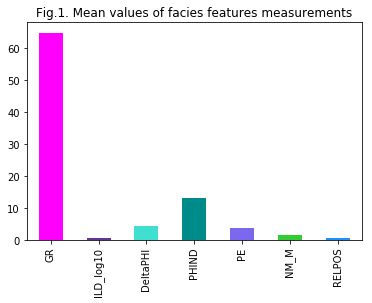

In [10]:
features = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE','NM_M', 'RELPOS']
feature_vectors = data[features]
feature_vectors.mean().plot(kind='bar',title='Fig.1. Mean values of facies features measurements', colors = cmap)

In [50]:
data_fl = pd.DataFrame ({'SS':268,'CSiS':940, 'FSiS':780, 'SiSh':271, 'MS':296, 'WS':582, 'D':141, 'PS':686, 'BS':185},index=['0','1'])
data_fl


,SS,CSiS,FSiS,SiSh,MS,WS,D,PS,BS
0,268,940,780,271,296,582,141,686,185
1,268,940,780,271,296,582,141,686,185


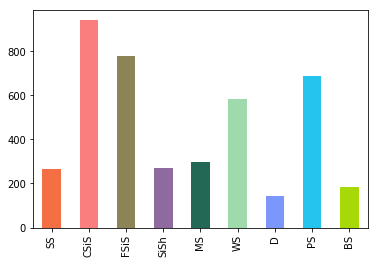

In [51]:
#ax = plt.subplot(3,4,1)
data_fl.mean().plot(kind = 'bar', colors = facies_colors)


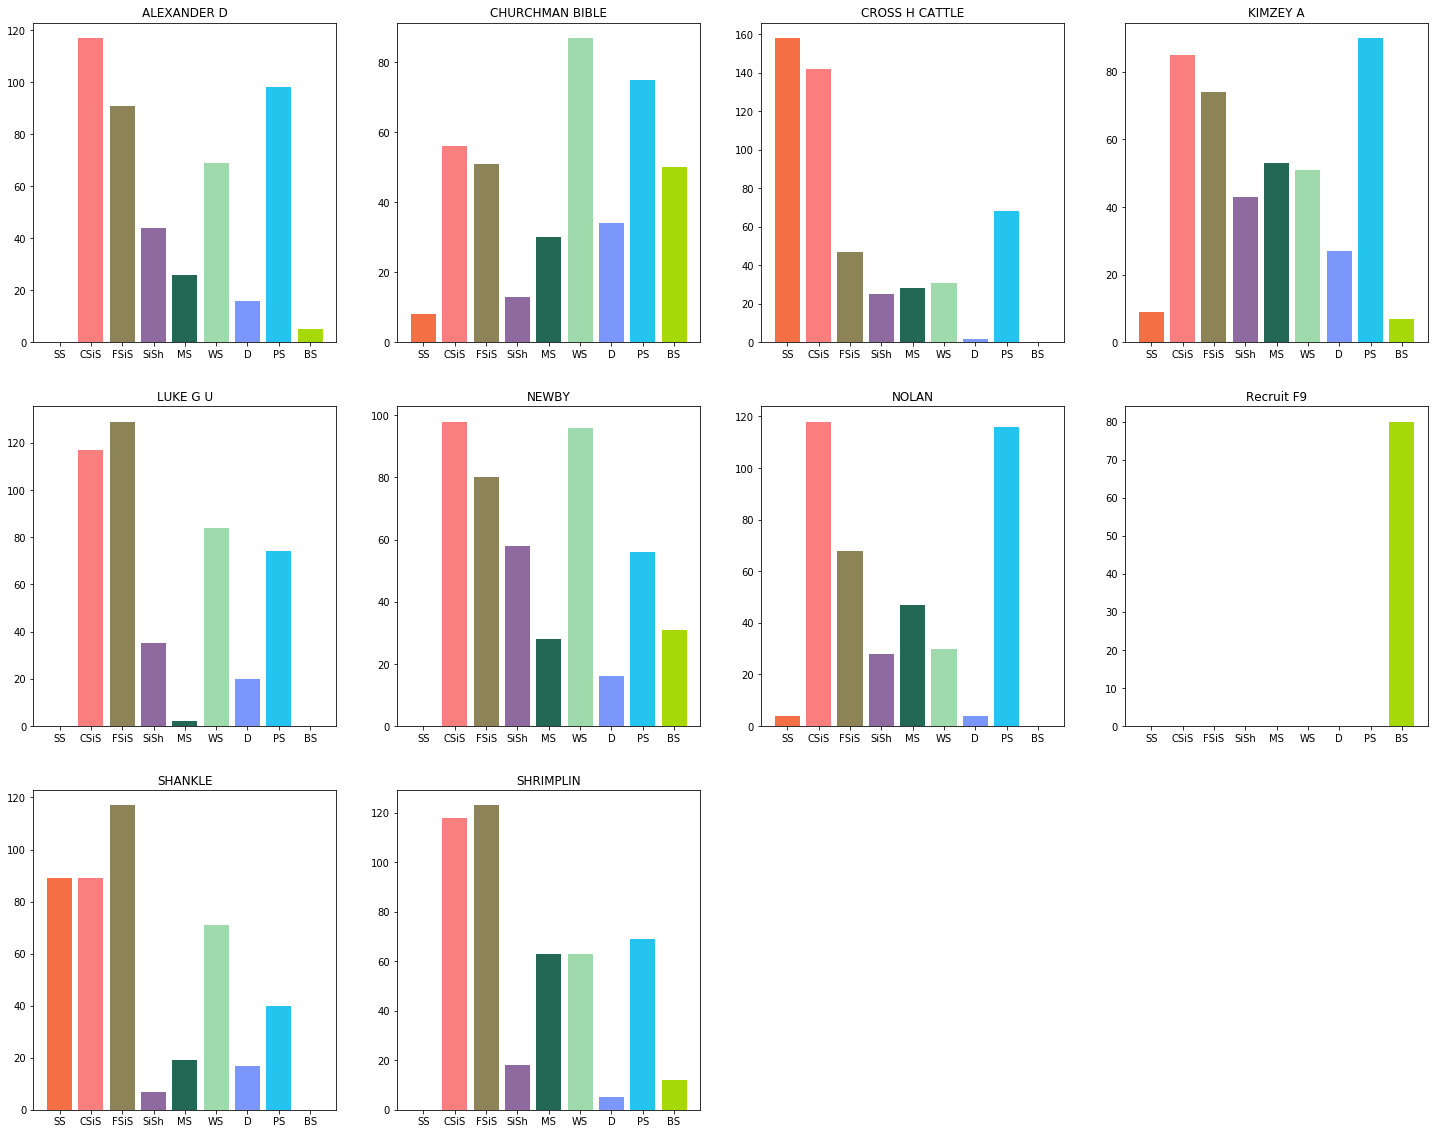

In [13]:
# Let's look at the distribution of facies in different wells
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F56F45', '#FA7E7E','#8C8456','#8F6A9E',
       '#226854','#9EDAAB', '#7C97FC', '#25C4EF', '#A7D909'] 
well = data['Well Name'].values
depth = data['Depth'].values
facies_numb = data['Facies'].values

plt.figure(figsize=(25,20))

for i, wn in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, i+1)
    hist = np.histogram(facies_numb[well == wn], bins=np.arange(10)+.7)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    ax.set_title(wn)
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_names)
# Скважина Recruit F9 - псевдо-скважина, введенная специально для улучшения качества классиификации фации BS
# Скважина KIMZEY A содержит все имеющиеся классы (типы фаций), поэтому в дальнейшем при  классификации 
# эта скважина будет сипользоваться в качестве тестовой

In [19]:
np.median([5,7,8])

7.0

In [11]:
wells = data['Well Name'].unique()
wells

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY',
       'CHURCHMAN BIBLE'], dtype=object)

In [12]:
data = data.drop(['Formation','RELPOS'],axis = 1)
data = data.sort_values('PE')
data = data.reset_index()
data.NM_M.replace(2,0,inplace=True)
data = data.drop(['index'],axis = 1)

In [13]:
real = ['GR','ILD_log10','DeltaPHI','PHIND']

In [14]:
real_data = data.drop(['Facies','Well Name','NM_M'],axis=1).fillna(data.mean())

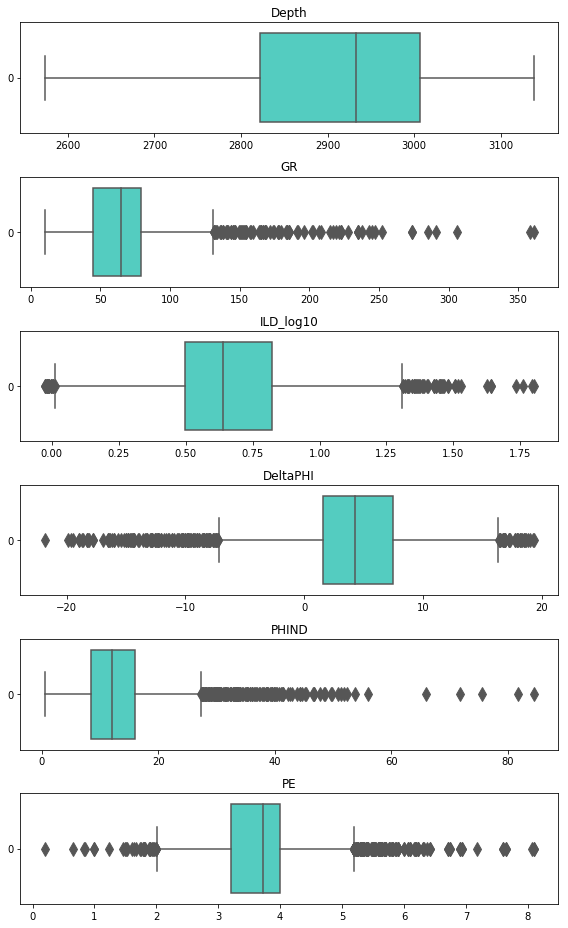

In [15]:
plot_boxplots(real_data)

### <font color = "limegreen"> EMD. </font>

In [16]:
Facies = data.Facies
Facies = pd.get_dummies(Facies)
PE = data.PE.dropna()
Depth = data.Depth
NM_M = data.NM_M
names = data['Well Name']
names.to_csv('names_col_sorted.csv')
names = pd.get_dummies(names)
#data = data.drop(['Facies','PE','Depth','NM_M','Well Name'],axis=1)
data = data.drop(['Facies','PE','NM_M'],axis=1)

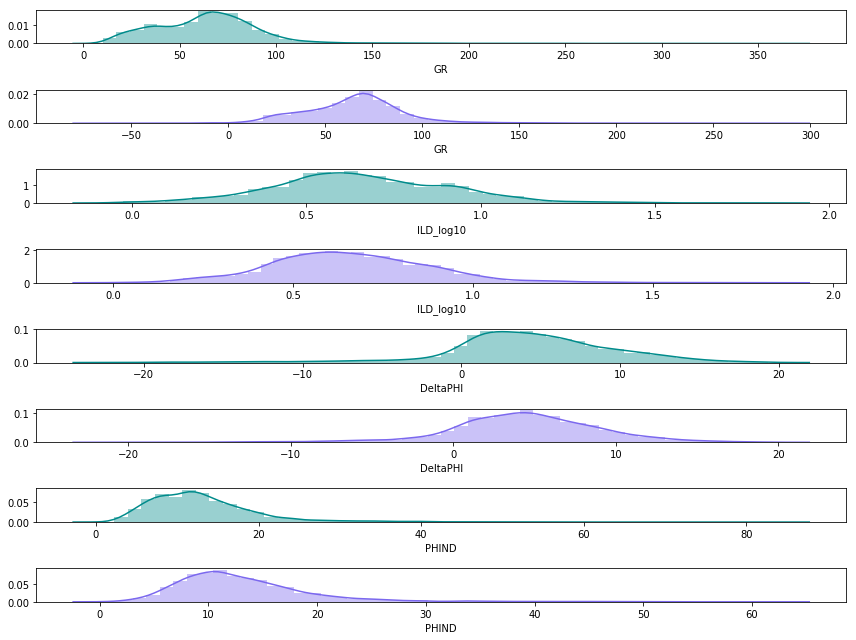

In [30]:
data_emd = pd.DataFrame(data)
plt.figure(figsize=(12,9))
plt.subplot(8,1,1)
sns.distplot(data_emd['GR'],color='darkcyan')
data_emd['GR'] = data_emd['GR']-EMD().emd(np.array(data_emd['GR']))[0]
plt.subplot(8,1,2)
sns.distplot(data_emd['GR'],color='mediumslateblue')
plt.subplot(8,1,3)
sns.distplot(data_emd['ILD_log10'],color='darkcyan')
data_emd['ILD_log10'] = data_emd['ILD_log10']-EMD().emd(np.array(data_emd['ILD_log10']))[0]
plt.subplot(8,1,4)
sns.distplot(data_emd['ILD_log10'],color='mediumslateblue')
plt.subplot(8,1,5)
sns.distplot(data_emd['DeltaPHI'],color='darkcyan')
data_emd['DeltaPHI'] = data_emd['DeltaPHI']-EMD().emd(np.array(data_emd['DeltaPHI']))[0]
plt.subplot(8,1,6)
sns.distplot(data_emd['DeltaPHI'],color='mediumslateblue')
plt.subplot(8,1,7)
sns.distplot(data_emd['PHIND'],color='darkcyan')
data_emd['PHIND'] = data_emd['PHIND']-EMD().emd(np.array(data_emd['PHIND']))[0]
plt.subplot(8,1,8)
sns.distplot(data_emd['PHIND'],color='mediumslateblue')
plt.tight_layout()
plt.show()

In [392]:
#data_emd.to_csv('data_emd_.csv',index = False)
data_emd = pd.read_csv('data_emd_.csv', encoding  = 'utf-8')
data_emd.head(10)

,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND
0,LUKE G U,2808.5,88.502397,0.575402,-4.939346,48.852072
1,CROSS H CATTLE,2788.0,88.051280,0.509701,-7.211033,57.805925
2,CROSS H CATTLE,2633.0,107.541489,0.537641,-6.643876,62.226960
3,CROSS H CATTLE,2633.5,122.416066,0.597912,-6.610304,59.450354
4,CROSS H CATTLE,2632.5,110.299264,0.576369,-8.244920,51.439194
5,LUKE G U,2808.0,89.543521,0.529882,-7.177263,45.880875
6,CROSS H CATTLE,2634.0,83.221072,0.537477,-2.673813,48.244631
7,CHURCHMAN BIBLE,3003.5,84.219034,0.580757,-5.118990,51.739156
8,SHANKLE,2858.0,79.996685,0.617481,-11.665840,52.072762
9,CHURCHMAN BIBLE,3004.0,64.848622,0.625056,-12.559401,47.958161


Text(0, 0.5, 'GR (API)')

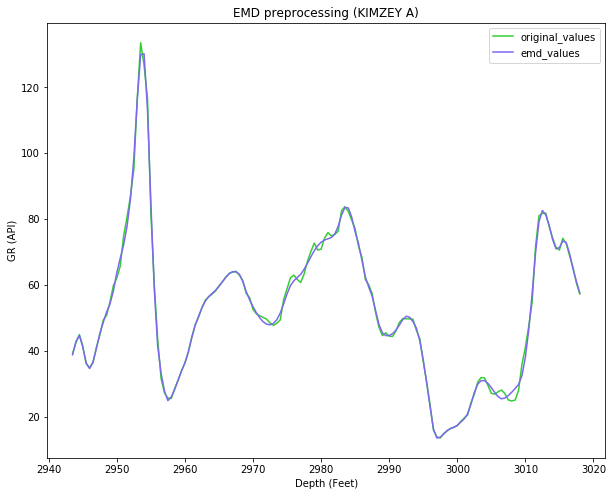

In [398]:
# KIMZEY A
data1 = facies_data[[features[0],'Depth']][facies_data['Well Name'] == wells[4]]
#data1 = data1.sort_values(by=['Depth'])
data1 = data1[50:200]
data2 = data_emd[[features[0],'Depth']][data_emd['Well Name'] == wells[4]]
data2 = data2.sort_values(by=['Depth'])
#data2.reset_index(inplace = True)
#data2 = data2.drop('index',axis=1)
data2 = data2[50:200]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR'], color ='mediumslateblue', label='emd_values')
plt.legend()

plt.title("EMD preprocessing (KIMZEY A)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

In [413]:
IMFs = emd(np.array(EMD_data[params[0]][EMD_data['Well Name'] == wells[2]]))

Text(0, 0.5, 'GR (API)')

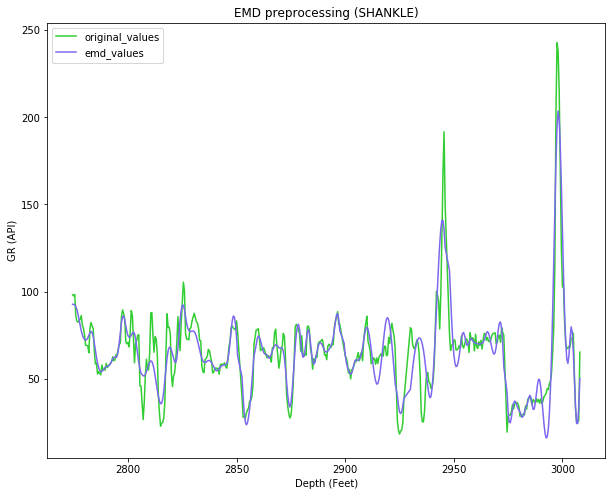

In [418]:
# SHANKLE
EMD_data = pd.read_csv ('EMD_data.csv',encoding = 'utf-8')
data1 = facies_data[[features[0],'Depth']][facies_data['Well Name'] == wells[2]]
#data1 = data1[0:150]
data2 = EMD_data[[features[0],'Depth']][EMD_data['Well Name'] == wells[2]]
data2 = data2.sort_values(by=['Depth'])
data2.reset_index(inplace = True)
data2 = data2.drop('index',axis=1)
#data2 = data2[0:150]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR'] - IMFs_[0] , color ='mediumslateblue', label='emd_values')
plt.legend()

plt.title("EMD preprocessing (SHANKLE)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

Text(0, 0.5, 'ILD_log10 (Ohms)')

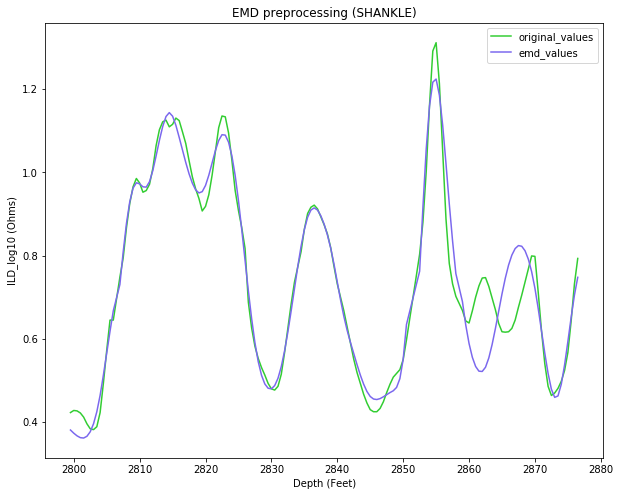

In [410]:
# SHANKLE
data1 = facies_data[[features[1],'Depth']][facies_data['Well Name'] == wells[2]]
data1 = data1[50:200]
data2 = EMD_data[[features[1],'Depth']][EMD_data['Well Name'] == wells[2]]
data2 = data2.sort_values(by=['Depth'])
data2.reset_index(inplace = True)
data2 = data2.drop('index',axis=1)
data2 = data2[50:200]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['ILD_log10'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['ILD_log10'], color ='mediumslateblue', label='emd_values')
plt.legend()

plt.title("EMD preprocessing (SHANKLE)")
plt.xlabel('Depth (Feet)')
plt.ylabel('ILD_log10 (Ohms)')

INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.


Text(0, 0.5, 'GR (API)')

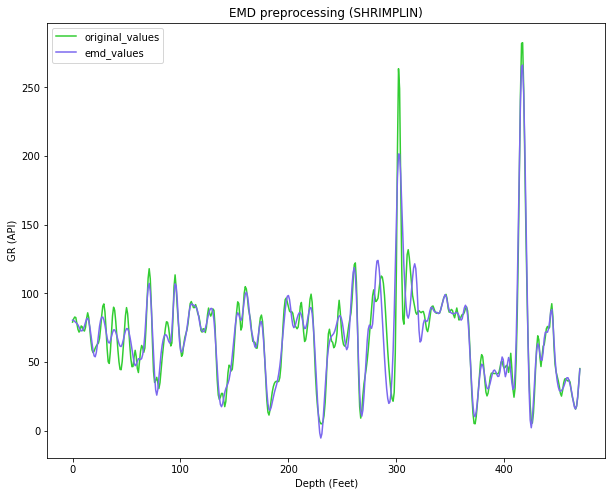

In [32]:
EMD_data = pd.DataFrame(data)
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']
emd = EMD()

for i in wells:
    for j in params:
        IMFs = emd(np.array(EMD_data[j][EMD_data['Well Name'] == i]))
        EMD_data[j][EMD_data['Well Name'] == i] -= IMFs[0]

EMD_data.isnull().any().any()

EMD_data.to_csv('EMD_data.csv', index = False)

IMFs = emd(np.array(EMD_data[params[0]][EMD_data['Well Name'] == wells[0]]))
plt.figure(figsize=(10,8))

plt.plot(EMD_data[params[0]][EMD_data['Well Name'] == wells[0]], color = 'limegreen', label = 'original_values')
plt.plot((EMD_data[params[0]][EMD_data['Well Name'] == wells[0]]-IMFs[0]),color ='mediumslateblue', label='emd_values')
plt.legend()
plt.title("EMD preprocessing (SHRIMPLIN)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')


In [305]:
EMD_data = pd.read_csv('EMD_data.csv',encoding = 'utf-8')
emd = EMD()
IMFs = emd(np.array(EMD_data[features[0]][EMD_data['Well Name'] == wells[0]]))

In [300]:
imfs1, res1 = emd.get_imfs_and_residue()

In [301]:
res1.max()

1.4210854715202004e-14

In [312]:
#SNR is a crucial indicator of signal quality
t1 = data['GR'].values
t2 = EMD_data['GR'].values
s1,s2 = 0,0
for e in t1:
    s1+=e**2
for e in t2:
    s2+=e**2
print(10* np.log (s1/s2))
    

-1.213736922724447


In [313]:
#SNR is a crucial indicator of signal quality
t1 = data['GR'].values
t2 = data_emd['GR'].values
s1,s2 = 0,0
for e in t1:
    s1+=e**2
for e in t2:
    s2+=e**2
print(10* np.log (s1/s2))

-0.41154893323957004


In [302]:
data_emd_ = pd.read_csv('data_emd.csv',encoding = 'utf-8')
emd = EMD()
IMFs = emd(np.array(data_emd_[features[0]][data_emd_['Well Name'] == wells[0]]))

In [303]:
imfs_1, res_1 = emd.get_imfs_and_residue()

In [304]:
res_1.max()

72.8687736738346

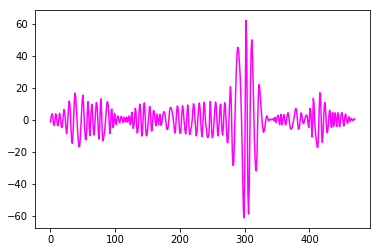

In [33]:
plt.plot(IMFs[0])

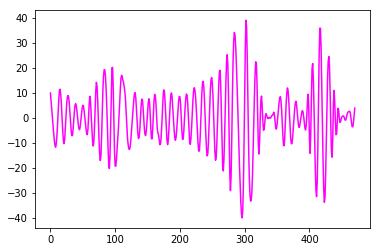

In [34]:
plt.plot(IMFs[1])

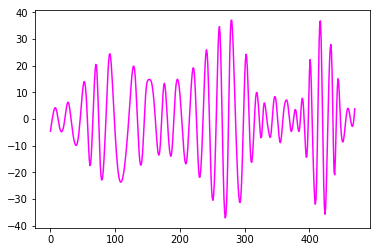

In [35]:
plt.plot(IMFs[2])

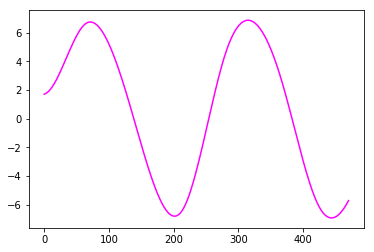

In [38]:
plt.plot(IMFs[7])

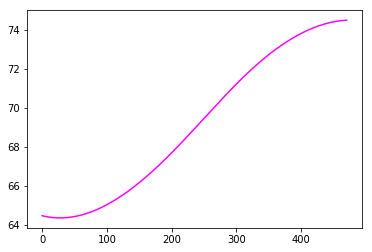

In [39]:
plt.plot(IMFs[8])

Text(0, 0.5, 'GR (API)')

<Figure size 720x576 with 0 Axes>

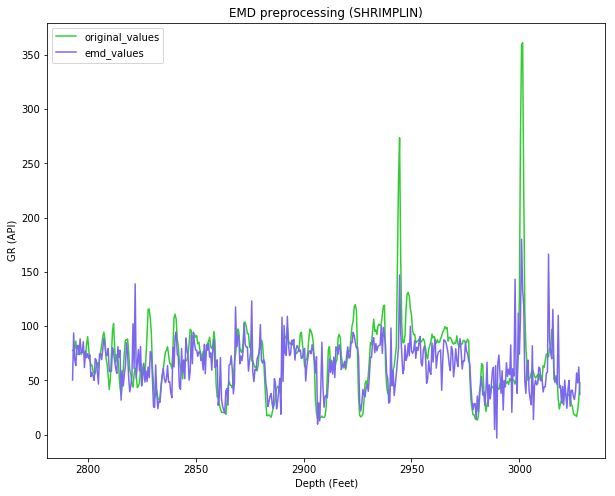

In [368]:
plt.figure(figsize=(10,8))
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']
data1 = facies_data[[features[0],'Depth']][facies_data['Well Name'] == wells[0]]
data1 = data1.sort_values(by=['Depth'])
#data1 = data1[50:200]
data2 = data_emd[[features[0],'Depth']][data_emd['Well Name'] == wells[0]]
data2 = data2.sort_values(by=['Depth'])
#data2 = data2[50:200]
IMFs_ = IMFs[0]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR'], color ='mediumslateblue', label='emd_values')
plt.legend()
#-IMFs_[50:200]
plt.title("EMD preprocessing (SHRIMPLIN)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')


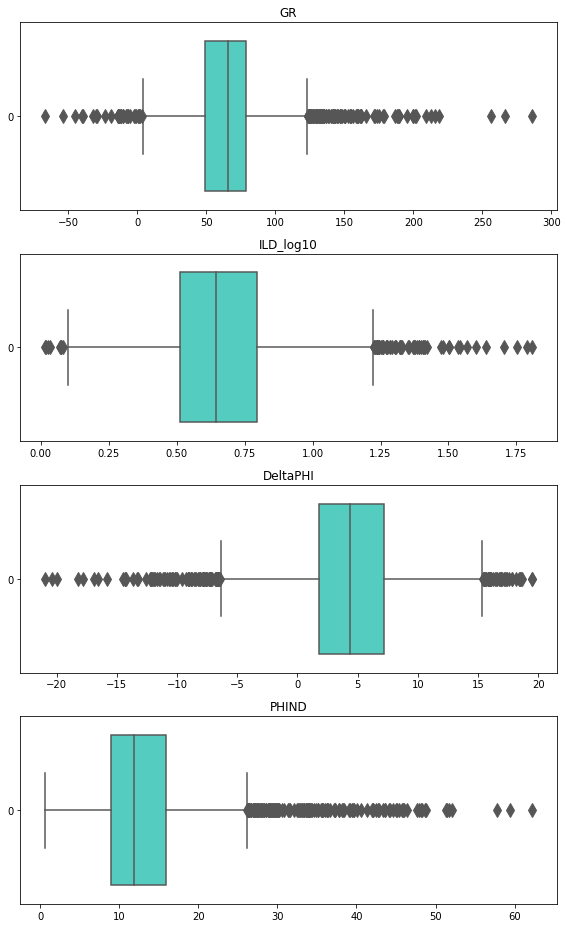

In [104]:
plot_boxplots(data_emd[real])

### <font color = "limegreen"> EEMD. </font>

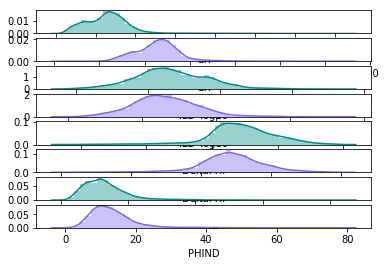

In [67]:
data_eemd = pd.DataFrame(data)
plt.subplot(8,1,1)
sns.distplot(data_eemd['GR'],color='darkcyan')
data_eemd['GR'] = data_eemd['GR']-EEMD(max_imf=5).eemd(np.array(data_eemd['GR']))[0]
plt.subplot(8,1,2)
sns.distplot(data_eemd['GR'],color='mediumslateblue')
plt.subplot(8,1,3)
sns.distplot(data_eemd['ILD_log10'],color='darkcyan')
data_eemd['ILD_log10'] = data_eemd['ILD_log10']-EEMD(max_imf=5).eemd(np.array(data_eemd['ILD_log10']))[0]
plt.subplot(8,1,4)
sns.distplot(data_eemd['ILD_log10'],color='mediumslateblue')
plt.subplot(8,1,5)
sns.distplot(data_eemd['DeltaPHI'],color='darkcyan')
data_eemd['DeltaPHI'] = data_eemd['DeltaPHI']-EEMD(max_imf=5).eemd(np.array(data_eemd['DeltaPHI']))[0]
plt.subplot(8,1,6)
sns.distplot(data_eemd['DeltaPHI'],color='mediumslateblue')
plt.subplot(8,1,7)
sns.distplot(data_eemd['PHIND'],color='darkcyan')
data_eemd['PHIND'] = data_eemd['PHIND']-EEMD(max_imf=5).eemd(np.array(data_eemd['PHIND']))[0]
plt.subplot(8,1,8)
sns.distplot(data_eemd['PHIND'],color='mediumslateblue')
plt.tight_layout()
plt.show()

In [73]:
data_eemd.to_csv('data_eemd.csv', index = False)

In [76]:
data_eemd = pd.read_csv('data_eemd.csv',encoding = 'utf-8')

In [354]:
wells

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY',
       'CHURCHMAN BIBLE'], dtype=object)

Text(0, 0.5, 'GR (API)')

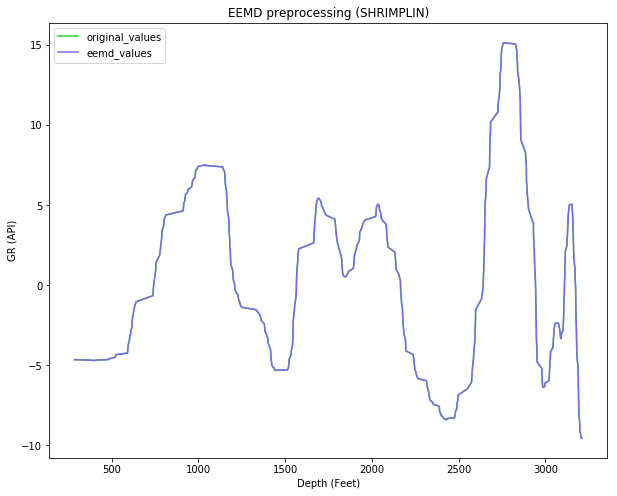

In [358]:
EEMD_data = pd.DataFrame(data)
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']
eemd = EEMD(max_imf=5)

for i in wells:
    for j in params:
        IMFs = eemd(np.array(EEMD_data[j][EEMD_data['Well Name'] == i]))
        if i == 'ALEXANDER D' or i== 'Recruit F9' or i == 'KIMZEY A':
            if j!=4 and len(IMFs) >=7 :
                 EEMD_data[j][EEMD_data['Well Name'] == i] = IMFs[4] + IMFs[5] + IMFs[6]
            elif j!=4 and len(IMFs) <= 2:
                EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] 
        elif len(IMFs) >= 7:
            EEMD_data[j][EEMD_data['Well Name'] == i] = IMFs[4] + IMFs[5] + IMFs[6]
        elif len(IMFs) >= 5:
            EEMD_data[j][EEMD_data['Well Name'] == i] = IMFs[2] + IMFs[3] + IMFs[4]
        elif len(IMFs) >= 4:
            EEMD_data[j][EEMD_data['Well Name'] == i] = IMFs[1] + IMFs[2] + IMFs[3]
        else :
            EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] 
        
        #if len(IMFs) > 3 and len(IMFs) > 7:
        #   EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[3]
EEMD_data.isnull().any().any()

EEMD_data.to_csv('EEMD_data_23.csv', index = False)

IMFs = eemd(np.array(EEMD_data[params[0]][EEMD_data['Well Name'] == wells[0]]))
plt.figure(figsize=(10,8))

plt.plot(data[params[0]][data['Well Name'] == wells[0]], color = 'limegreen', label = 'original_values')
plt.plot((EEMD_data[params[0]][EEMD_data['Well Name'] == wells[0]]),color ='mediumslateblue', label='eemd_values')
plt.legend()
plt.title("EEMD preprocessing (SHRIMPLIN)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

In [349]:
IMFs = eemd(np.array(data[params[3]][data['Well Name'] == wells[1]]))
len(IMFs)

9

In [383]:
### !!!!!!!!!!!!
EEMD_data = pd.DataFrame(data)
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']
eemd = EEMD(max_imf=5)

for i in wells:
    for j in params:
        IMFs = eemd(np.array(EEMD_data[j][EEMD_data['Well Name'] == i]))
        if i == 'ALEXANDER D' or i== 'Recruit F9' or i == 'KIMZEY A':
            if j!=4 and len(IMFs) >=7 :
                 EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] + IMFs[1] + IMFs[2] + IMFs[3]
            elif j!=4 and len(IMFs) <= 2:
                EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] 
        elif len(IMFs) >= 7:
            EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] + IMFs[1] + IMFs[2] + IMFs[3]
        elif len(IMFs) >= 5:
            EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] + IMFs[1] + IMFs[2] 
        elif len(IMFs) >= 4:
            EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] + IMFs[1] 
        else :
            EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] 
        
        #if len(IMFs) > 3 and len(IMFs) > 7:
        #   EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[3]
EEMD_data.isnull().any().any()

EEMD_data.to_csv('EEMD_data_23new.csv', index = False)

Text(0, 0.5, 'GR (API)')

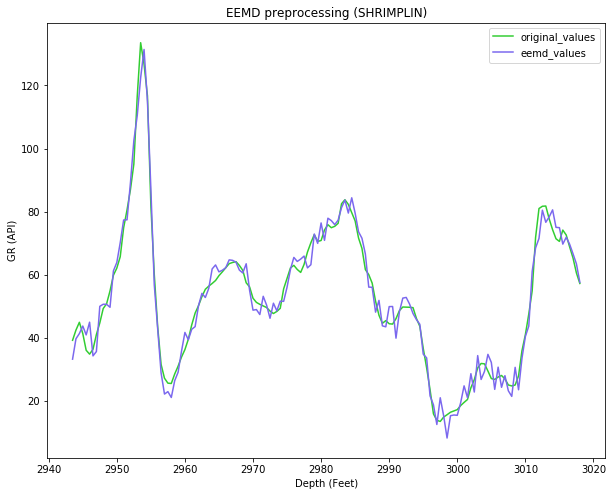

In [385]:
EEMD_data = pd.read_csv('EEMD_data.csv', encoding = 'utf-8')
data1 = facies_data[[features[0],'Depth']][facies_data['Well Name'] == wells[4]]
data1 = data1[50:200]
data2 = EEMD_data[[features[0],'Depth']][EEMD_data['Well Name'] == wells[4]]
data2 = data2.sort_values(by=['Depth'])
data2.reset_index(inplace = True)
data2 = data2.drop('index',axis=1)
data2 = data2[50:200]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'], data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'], data2['GR'], color ='mediumslateblue', label='eemd_values')
plt.legend()
plt.title("EEMD preprocessing (SHRIMPLIN)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

Text(0, 0.5, 'GR (API)')

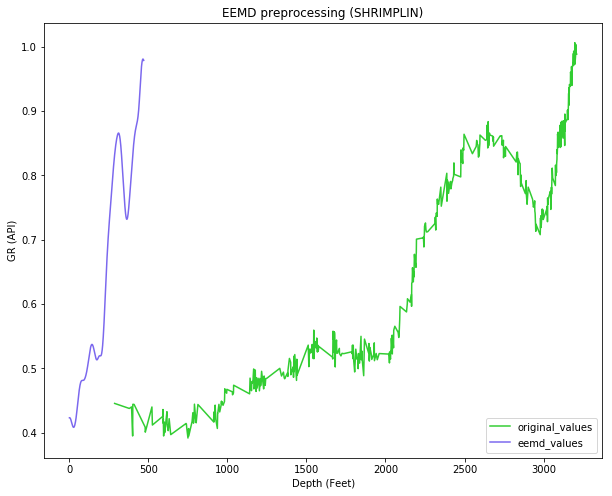

In [339]:
plt.figure(figsize=(10,8))
plt.plot(data[params[1]][data['Well Name'] == wells[0]], color = 'limegreen', label = 'original_values')
plt.plot((IMFs[4]+IMFs[5]+IMFs[6]),color ='mediumslateblue', label='eemd_values')
plt.legend()
plt.title("EEMD preprocessing (SHRIMPLIN)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

In [283]:
EEMD_data = pd.read_csv('EEMD_data.csv',encoding = 'utf-8')
eemd = EEMD(max_imf=5)
IMFs = eemd(np.array(EEMD_data[features[0]][EEMD_data['Well Name'] == wells[4]]))

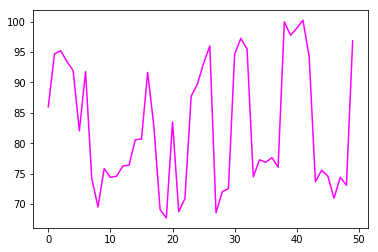

In [298]:
#plt.plot(EEMD_data['GR'][0:50])
plt.plot(data['GR'][0:50])

In [353]:
features[4]

'ALEXANDER D'

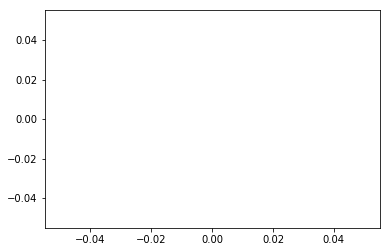

In [351]:
data1 = data[[features[4],'Depth']][data['Well Name'] == wells[1]]
#data1 = data1[50:200]
plt.plot(data1['PE'])

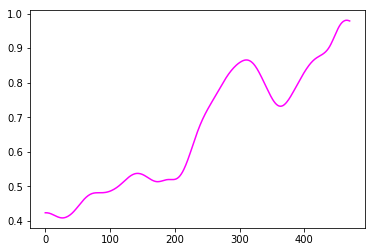

In [344]:
#3
plt.plot(IMFs[4]+IMFs[5]+IMFs[6])

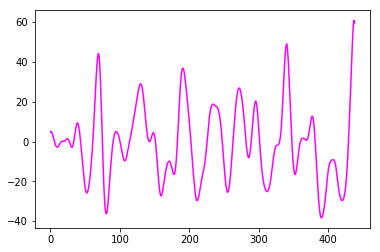

In [257]:
plt.plot(IMFs[3]+IMFs[4]+IMFs[5])

In [1]:
IMFs = eemd(np.array(EEMD_data[features[0]][EEMD_data['Well Name'] == wells[0]]))

NameError: name 'eemd' is not defined

Text(0, 0.5, 'GR (API)')

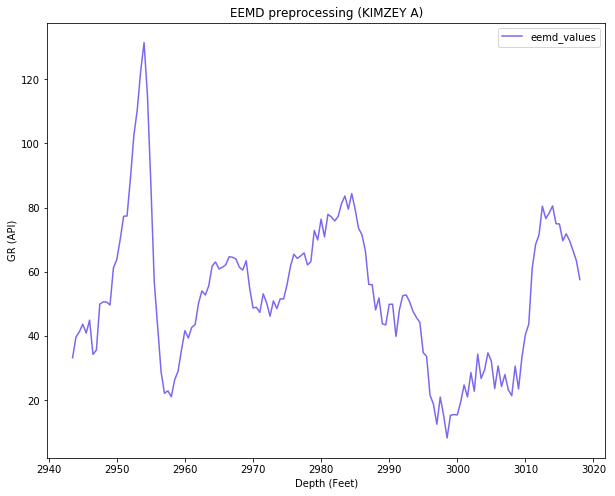

In [379]:
# KIMZEY A
data1 = facies_data[[features[0],'Depth']][facies_data['Well Name'] == wells[4]]
data1 = data1[50:200]
EEMD_data1 = pd.read_csv('EEMD_data.csv',encoding = 'utf-8')
data2 = EEMD_data1[[features[0],'Depth']][EEMD_data1['Well Name'] == wells[4]]
data2 = data2.sort_values(by=['Depth'])
data2 = data2[50:200]
IMFs_0,IMFs_1,IMFs_2 = IMFs[0],IMFs[1],IMFs[2]
IMFs_3,IMFs_4,IMFs_5 = IMFs[3],IMFs[4],IMFs[5]
IMFs_6,IMFs_7,IMFs_8 = IMFs[6],IMFs[7],IMFs[8]
IMFs_sum = IMFs[0]+IMFs[1]+IMFs[2]
#+IMFs[1]+IMFs[2]+IMFs_3+IMFs_4+IMFs_5+ IMFs[6]+IMFs[7]+IMFs[8]
plt.figure(figsize=(10,8))
#plt.plot(data1['Depth'], data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'] , data2['GR'], color ='mediumslateblue', label='eemd_values')
plt.legend()

plt.title("EEMD preprocessing (KIMZEY A)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

In [58]:
res.max()

1.4210854715202004e-14

In [57]:
res

array([-1.42108547e-14,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -7.10542736e-15,  0.00000000e+00,
        0.00000000e+00, -7.10542736e-15,  7.10542736e-15, -7.10542736e-15,
       -7.10542736e-15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.42108547e-14,  0.00000000e+00,
        0.00000000e+00, -7.10542736e-15,  7.10542736e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -7.10542736e-15,  0.00000000e+00, -7.10542736e-15,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

Text(0, 0.5, 'GR (API)')

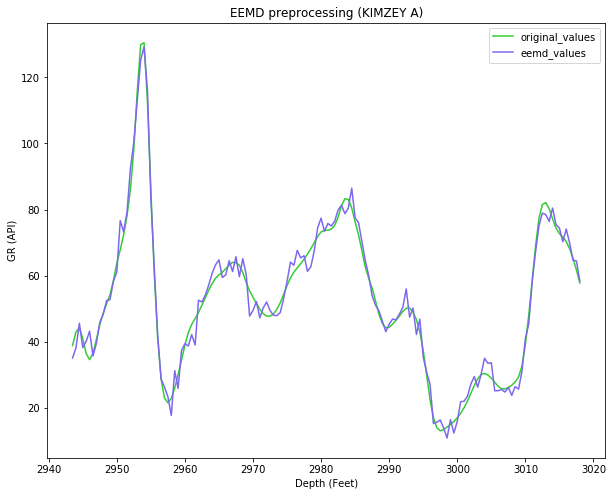

In [46]:
# KIMZEY A
EEMD_data = pd.read_csv('EEMD_data.csv', encoding = 'utf-8')
data1 = data[[features[0],'Depth']][data['Well Name'] == wells[4]]
data1 = data1.sort_values(by=['Depth'])
data1 = data1[50:200]
data2 = EEMD_data[[features[0],'Depth']][EEMD_data['Well Name'] == wells[4]]
data2['GR'] = data2['GR']-IMFs[0]
data2 = data2.sort_values(by=['Depth'])
data2 = data2[50:200]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR'], color ='mediumslateblue', label='eemd_values')
plt.legend()

plt.title("EEMD preprocessing (KIMZEY A)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

In [47]:
# SHRIMPLIN
EEMD_data = pd.read_csv('EEMD_data.csv', encoding = 'utf-8')
data1 = data[[features[0],'Depth']][data['Well Name'] == wells[0]]
data1 = data1.sort_values(by=['Depth'])
data1 = data1[50:200]
data2 = EEMD_data[[features[0],'Depth']][EEMD_data['Well Name'] == wells[0]]
data2['GR'] = data2['GR']-IMFs[0]
data2 = data2.sort_values(by=['Depth'])
data2 = data2[50:200]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR'], color ='mediumslateblue', label='eemd_values')
plt.legend()

plt.title("EEMD preprocessing (SHRIMPLIN)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

ValueError: operands could not be broadcast together with shapes (471,) (439,) 

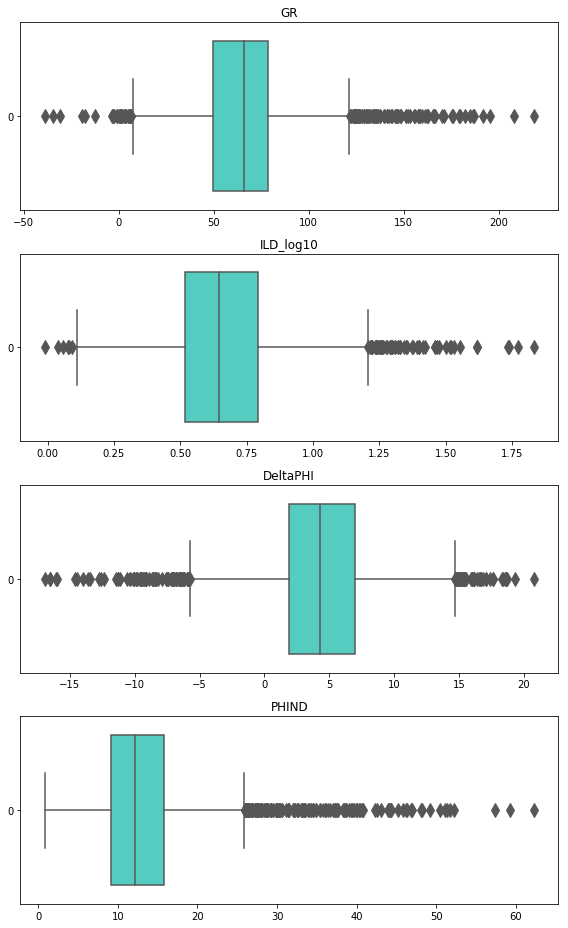

In [16]:
plot_boxplots(data_eemd[real])

### <font color = "limegreen"> CEEMD. </font>

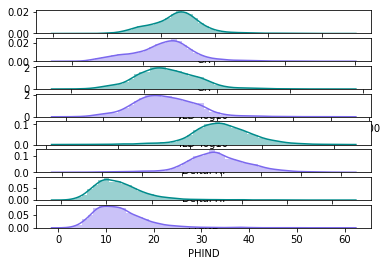

In [17]:
data_ceemd = pd.DataFrame(data)
plt.subplot(8,1,1)
sns.distplot(data_ceemd['GR'],color='darkcyan')
data_ceemd['GR'] = data_eemd['GR']-CEEMDAN().ceemdan(np.array(data_ceemd['GR']))[0]
plt.subplot(8,1,2)
sns.distplot(data_ceemd['GR'],color='mediumslateblue')
plt.subplot(8,1,3)
sns.distplot(data_ceemd['ILD_log10'],color='darkcyan')
data_ceemd['ILD_log10'] = data_eemd['ILD_log10']-CEEMDAN().ceemdan(np.array(data_ceemd['ILD_log10']))[0]
plt.subplot(8,1,4)
sns.distplot(data_ceemd['ILD_log10'],color='mediumslateblue')
plt.subplot(8,1,5)
sns.distplot(data_ceemd['DeltaPHI'],color='darkcyan')
data_ceemd['DeltaPHI'] = data_eemd['DeltaPHI']-CEEMDAN().ceemdan(np.array(data_ceemd['DeltaPHI']))[0]
plt.subplot(8,1,6)
sns.distplot(data_ceemd['DeltaPHI'],color='mediumslateblue')
plt.subplot(8,1,7)
sns.distplot(data_ceemd['PHIND'],color='darkcyan')
data_ceemd['PHIND'] = data_eemd['PHIND']-CEEMDAN().ceemdan(np.array(data_ceemd['PHIND']))[0]
plt.subplot(8,1,8)
sns.distplot(data_ceemd['PHIND'],color='mediumslateblue')
plt.tight_layout()
plt.show()

In [187]:
data_ceemd = pd.read_csv('data_ceemd.csv',encoding = 'utf-8')
data_ceemd['Depth'] = data['Depth']
data_ceemd['Facies'] = data['Facies']
data_ceemd.head()

,Unnamed: 0,Well Name,GR,ILD_log10,DeltaPHI,PHIND,Depth,Facies
0,0,LUKE G U,90.652386,0.559498,-6.108249,53.129950,2808.5,3
1,1,CROSS H CATTLE,98.294043,0.549662,-5.756847,56.768430,2788.0,3
2,2,CROSS H CATTLE,103.957196,0.549513,-6.880142,58.976101,2633.0,2
3,3,CROSS H CATTLE,106.660976,0.578893,-7.833042,57.649025,2633.5,2
4,4,CROSS H CATTLE,105.475927,0.578020,-7.027230,53.783086,2632.5,3


Text(0, 0.5, 'GR (API)')

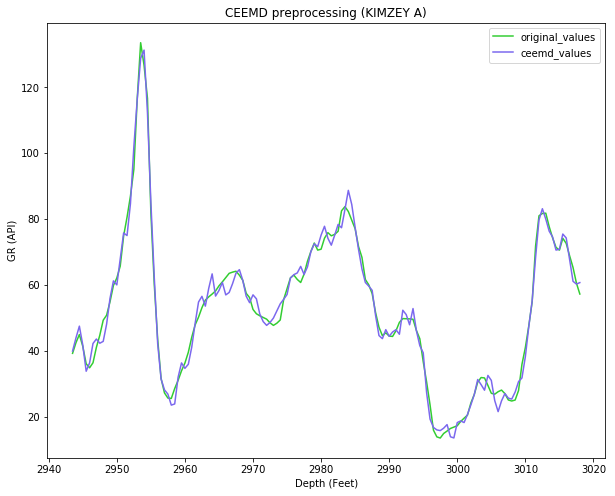

In [205]:
# KIMZEY A
data1 = data[[features[0],'Depth']][data['Well Name'] == wells[4]]
data1 = data1[50:200]
data1 = data1.sort_values(by=['Depth'])
data2 = data_ceemd[[features[0],'Depth']][data_ceemd['Well Name'] == wells[4]]
data2 = data2.sort_values(by=['Depth'])
data2 = data2[50:200]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR'], color ='mediumslateblue', label='ceemd_values')
plt.legend()

plt.title("CEEMD preprocessing (KIMZEY A)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

In [ ]:
CEEMD_data = pd.DataFrame(facies_data)
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']
ceemd = CEEMDAN()

for i in wells:
    for j in params:
        if j!=4 and i!= 'ALEXANDER D' and i!= 'KIMZEY A' and i!='Recruit F9':
            IMFs = ceemd(np.array(CEEMD_data[j][CEEMD_data['Well Name'] == i]))
            CEEMD_data[j][CEEMD_data['Well Name'] == i] -= IMFs[0]

CEEMD_data.isnull().any().any()

CEEMD_data.to_csv('CEEMD_data.csv', index = False)


In [ ]:
IMFs = ceemd(np.array(CEEMD_data[params[0]][CEEMD_data['Well Name'] == wells[0]]))
plt.figure(figsize=(10,8))

plt.plot(CEEMD_data[params[0]][CEEMD_data['Well Name'] == wells[0]], color = 'limegreen', label = 'original_values')
plt.plot((CEEMD_data[params[0]][CEEMD_data['Well Name'] == wells[0]]-IMFs[0]),color ='mediumslateblue', label='ceemdan_values')
plt.legend()
plt.title("CEEMDAN preprocessing (SHRIMPLIN)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

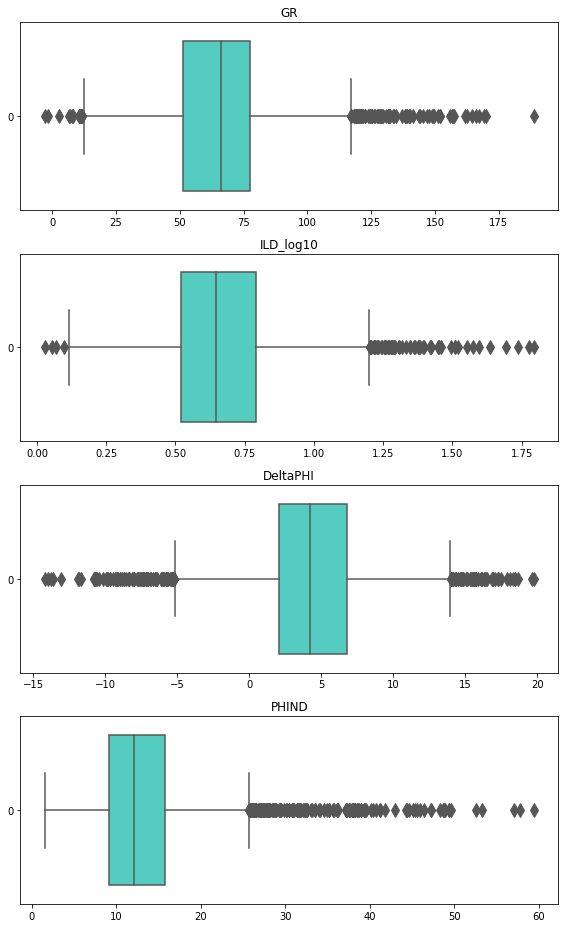

In [18]:
plot_boxplots(data_ceemd[real])

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler, PowerTransformer

# $$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$


In [19]:
def combine_dataframe(df,norm):
    df['Depth'] = Depth
    temp_df = pd.DataFrame(norm.fit_transform(df))
    temp_df.NM = NM_M
    for col in Facies.columns:
        col_name = 'Faci'+str(col)
        temp_df[col_name] = Facies[col]
    return temp_df

In [20]:
def combine_dataframe_(df,norm):
    df['Depth'] = Depth
    temp_df = df[['GR','ILD_log10','DeltaPHI','PHIND','Depth']]
    temp_df = pd.DataFrame(norm.fit_transform(temp_df))
    #temp_df['NM'] = NM_M
    for col in Facies.columns:
        col_name = 'Faci'+str(col)
        temp_df[col_name] = Facies[col]
    return temp_df

In [ ]:
data_emd_ss = combine_dataframe(data_emd,StandardScaler())


In [ ]:
data_emd_ss = combine_dataframe(data_emd,StandardScaler())
data_emd_mm = combine_dataframe(data_emd,MinMaxScaler())
data_emd_qt = combine_dataframe(data_emd,QuantileTransformer())

data_emd_rs = combine_dataframe(data_emd,RobustScaler())

data_emd_pt = combine_dataframe(data_emd,PowerTransformer(method='yeo-johnson',standardize=True))


In [ ]:
data_emd_ss.to_csv('data_emd_ss.csv')
data_emd_mm.to_csv('data_emd_mm.csv')
data_emd_qt.to_csv('data_emd_qt.csv')
data_emd_rs.to_csv('data_emd_rs.csv')
data_emd_pt.to_csv('data_emd_pt.csv')

In [ ]:
data_eemd_ss = combine_dataframe(data_eemd,StandardScaler())
data_eemd_mm = combine_dataframe(data_eemd,MinMaxScaler())
data_eemd_qt = combine_dataframe(data_eemd,QuantileTransformer())
data_eemd_rs = combine_dataframe(data_eemd,RobustScaler())
data_eemd_pt = combine_dataframe(data_eemd,PowerTransformer(method='yeo-johnson',standardize=True))

In [ ]:
data_eemd_ss.to_csv('data_eemd_ss.csv')
data_eemd_mm.to_csv('data_eemd_mm.csv')
data_eemd_qt.to_csv('data_eemd_qt.csv')
data_eemd_rs.to_csv('data_eemd_rs.csv')
data_eemd_pt.to_csv('data_eemd_pt.csv')

In [ ]:
data_ceemd_ss = combine_dataframe(data_ceemd,StandardScaler())
data_ceemd_mm = combine_dataframe(data_ceemd,MinMaxScaler())
data_ceemd_qt = combine_dataframe(data_ceemd,QuantileTransformer())
data_ceemd_rs = combine_dataframe(data_ceemd,RobustScaler())
data_ceemd_pt = combine_dataframe(data_ceemd,PowerTransformer(method='yeo-johnson',standardize=True))

In [ ]:
data_ceemd_ss.to_csv('data_ceemd_ss.csv')
data_ceemd_mm.to_csv('data_ceemd_mm.csv')
data_ceemd_qt.to_csv('data_ceemd_qt.csv')
data_ceemd_rs.to_csv('data_ceemd_rs.csv')
data_ceemd_pt.to_csv('data_ceemd_pt.csv')

In [21]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,AdaBoostClassifier,AdaBoostRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score, train_test_split
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [22]:
models = [RandomForestRegressor(),XGBRegressor(),AdaBoostRegressor(),KNeighborsRegressor(),Lasso(),Ridge()]
names = ['RF','XGB','Ada','KNeighbors','L1 regularized linear','L2 regularized linear']
params = [{'n_estimators':[10,20,30,50,80,100,150,200,300],
           'max_depth':[2,3,4,5,6],
          'max_features':['auto','sqrt']},
          {'n_estimators':[10,20,30,100,150,200,300],
           'max_depth':[2,3,4,5,6,7],
           'learning_rate':np.arange(0.1,1.0,0.1)},
         {'n_estimators':[10,20,30,50,80,100,150,200,300],
          'learning_rate':np.arange(0.1,2.0,0.1)},
         {'n_neighbors':np.arange(2,20,1),
         'weights':['uniform','distance'],
         'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']},
         {'alpha':np.arange(0.1,1.0,0.05)}, {'alpha':np.arange(0.1,1.0,0.05)}]

In [23]:
def print_regression_stats(name,model):
    print(name+'\n')
    print('Params are:'+str(model.best_params_))
    print('MSE'+str(model.best_score_))

def print_r2_scores(models,x,y_true,model_names):
    for i,model in enumerate(models):
        print ("For model {} MSE score is: {}".format(model_names[i],mean_squared_error(y_true,model.predict(x))))
        print ("For model {} MAE score is: {}".format(model_names[i],mean_absolute_error(y_true,model.predict(x))))        
        print ("For model {} R2 score is: {}".format(model_names[i],r2_score(y_true,model.predict(x))))    
        
def fit_best_estimator(data_train,y_test,df_type_name):
    print ('Now its {} noise and preprocessing types'.format(df_type_name))
    saved_models = list()
    y = data_train.PE
    data_train = data_train.drop(['PE'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(data_train, y, test_size=0.25)
    for i in range(len(models)):
        model = GridSearchCV(models[i],params[i],scoring='neg_mean_squared_error',cv=6)
        model.fit(X_train,y_train)
        saved_models.append(model)
        print_regression_stats(names[i],model)
    print_r2_scores(saved_models,X_test,y_test,names)
    print('\n\n')

In [24]:
def prepare_data(df,norm):
    pe = norm.fit_transform(np.array(PE).reshape(-1,1))
    df_train = df[:-917]
    df_train['PE'] = pe
    df_test = df[-917:]
    return df_train, df_test

In [144]:
data_emd_ss = pd.read_csv('data_emd_ss.csv',encoding = 'utf-8')
data_emd_mm = pd.read_csv('data_emd_mm.csv',encoding = 'utf-8')
data_emd_qt = pd.read_csv('data_emd_qt.csv',encoding = 'utf-8')
data_emd_rs = pd.read_csv('data_emd_rs.csv',encoding = 'utf-8')
data_emd_pt = pd.read_csv('data_emd_pt.csv',encoding = 'utf-8')

In [145]:
emd_ss_train,emd_ss_test = prepare_data(data_emd_ss,StandardScaler())
emd_mm_train,emd_mm_test = prepare_data(data_emd_mm,MinMaxScaler())
emd_qt_train,emd_qt_test = prepare_data(data_emd_qt,QuantileTransformer())
emd_rs_train,emd_rs_test = prepare_data(data_emd_rs,RobustScaler())
emd_pt_train,emd_pt_test = prepare_data(data_emd_pt,PowerTransformer(method='yeo-johnson',standardize=True))

In [146]:
data_eemd_ss = pd.read_csv('data_eemd_ss.csv',encoding = 'utf-8')
data_eemd_mm = pd.read_csv('data_eemd_mm.csv',encoding = 'utf-8')
data_eemd_qt = pd.read_csv('data_eemd_qt.csv',encoding = 'utf-8')
data_eemd_rs = pd.read_csv('data_eemd_rs.csv',encoding = 'utf-8')
data_eemd_pt = pd.read_csv('data_eemd_pt.csv',encoding = 'utf-8')

In [147]:
eemd_ss_train,eemd_ss_test = prepare_data(data_eemd_ss,StandardScaler())
eemd_mm_train,eemd_mm_test = prepare_data(data_eemd_mm,MinMaxScaler())
eemd_qt_train,eemd_qt_test = prepare_data(data_eemd_qt,QuantileTransformer())
eemd_rs_train,eemd_rs_test = prepare_data(data_eemd_rs,RobustScaler())
eemd_pt_train,eemd_pt_test = prepare_data(data_eemd_pt,PowerTransformer(method='yeo-johnson',standardize=True))

In [148]:
data_ceemd_ss = pd.read_csv('data_ceemd_ss.csv',encoding = 'utf-8')
data_ceemd_mm = pd.read_csv('data_ceemd_mm.csv',encoding = 'utf-8')
data_ceemd_qt = pd.read_csv('data_ceemd_qt.csv',encoding = 'utf-8')
data_ceemd_rs = pd.read_csv('data_ceemd_rs.csv',encoding = 'utf-8')
data_ceemd_pt = pd.read_csv('data_ceemd_pt.csv',encoding = 'utf-8')

In [149]:
ceemd_ss_train,ceemd_ss_test = prepare_data(data_ceemd_ss,StandardScaler())
ceemd_mm_train,ceemd_mm_test = prepare_data(data_ceemd_mm,MinMaxScaler())
ceemd_qt_train,ceemd_qt_test = prepare_data(data_ceemd_qt,QuantileTransformer())
ceemd_rs_train,ceemd_rs_test = prepare_data(data_ceemd_rs,RobustScaler())
ceemd_pt_train,ceemd_pt_test = prepare_data(data_ceemd_pt,PowerTransformer(method='yeo-johnson',standardize=True))

In [124]:
EMD_data = pd.read_csv('EMD_data.csv',encoding = 'utf-8')
#EMD_data = EMD_data.drop(['Formation','RELPOS'],axis = 1)
EMD_data = EMD_data.sort_values('PE')
EMD_data = EMD_data.reset_index()
EMD_data.NM_M.replace(2,0,inplace=True)
EMD_data = EMD_data.drop(['index'],axis = 1)
#data = data.drop(['Facies','PE','Depth','NM_M','Well Name'],axis=1)
#EMD_data_pt = combine_dataframe_(EMD_data,PowerTransformer(method='yeo-johnson',standardize=True))
#Facies = EMD_data.Facies
#Facies = pd.get_dummies(Facies)
#PE = EMD_data.PE.dropna()
#Depth = EMD_data.Depth
#NM_M = EMD_data.NM_M
#EMD_data = EMD_data.drop(['Depth'],axis = 1)
#EMD_data

In [125]:
data_emd_ss = combine_dataframe_(EMD_data,StandardScaler())
data_emd_mm = combine_dataframe_(EMD_data,MinMaxScaler())
data_emd_qt = combine_dataframe_(EMD_data,QuantileTransformer())
data_emd_rs = combine_dataframe_(EMD_data,RobustScaler())
data_emd_pt = combine_dataframe_(EMD_data,PowerTransformer(method='yeo-johnson',standardize=True))

In [126]:
emd_ss_train,emd_ss_test = prepare_data(data_emd_ss,StandardScaler())
emd_mm_train,emd_mm_test = prepare_data(data_emd_mm,MinMaxScaler())
emd_qt_train,emd_qt_test = prepare_data(data_emd_qt,QuantileTransformer())
emd_rs_train,emd_rs_test = prepare_data(data_emd_rs,RobustScaler())
emd_pt_train,emd_pt_test = prepare_data(data_emd_pt,PowerTransformer(method='yeo-johnson',standardize=True))

In [30]:
fit_best_estimator(emd_ss_train,emd_ss_test,'EMD, StandardScale')
fit_best_estimator(emd_mm_train,emd_mm_test,'EMD, MinMaxScale')
fit_best_estimator(emd_qt_train,emd_qt_test,'EMD, QuantileTransform')
fit_best_estimator(emd_rs_train,emd_rs_test,'EMD, RobustScale')                            
fit_best_estimator(emd_pt_train,emd_pt_test,'EMD, PowerTransform')

Now its EMD, StandardScale noise and preprocessing types
RF

Params are:{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 300}
MSE-0.27862158466713766
XGB

Params are:{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
MSE-0.23599213211332412
Ada

Params are:{'learning_rate': 1.0, 'n_estimators': 10}
MSE-0.3428750693494221
KNeighbors

Params are:{'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'distance'}
MSE-0.21553007404940877
L1 regularized linear

Params are:{'alpha': 0.1}
MSE-0.5242202419348942
L2 regularized linear

Params are:{'alpha': 0.9500000000000003}
MSE-0.3436065029360473
For model RF MSE score is: 0.2895189705141396
For model RF MAE score is: 0.3915198784438524
For model RF R2 score is: 0.7186047147741648
For model XGB MSE score is: 0.23436950598457335
For model XGB MAE score is: 0.3432260345080898
For model XGB R2 score is: 0.7722067266692418
For model Ada MSE score is: 0.36675422877224995
For model Ada MAE score is: 0.44733183531631304
For model Ada R2 

Shapiro-Wilk test for normality: (0.9954453110694885, 2.0223513530481796e-08)


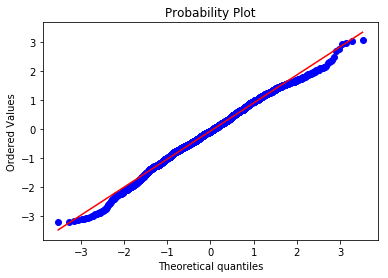

In [39]:
import matplotlib.pyplot as plt
import scipy.stats as stats
#data = np.random.uniform(size=100) 
stats.probplot(emd_pt_train[1], dist="norm", plot=plt)
print("Shapiro-Wilk test for normality:", stats.shapiro(emd_pt_train[1]))
plt.show()

Shapiro-Wilk test for normality: (0.9525806307792664, 3.689130093219518e-31)


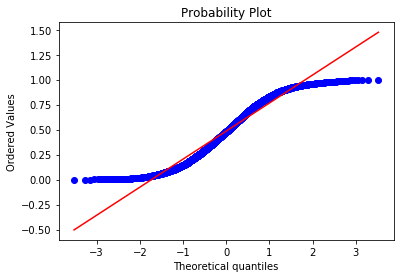

In [128]:
import matplotlib.pyplot as plt
import scipy.stats as stats
#data = np.random.uniform(size=100) 
stats.probplot(emd_qt_train[1], dist="norm", plot=plt)
print("Shapiro-Wilk test for normality:", stats.shapiro(emd_qt_train[1]))
plt.show()

In [40]:
EMD_data = pd.read_csv('EMD_data01.csv',encoding = 'utf-8')
#EMD_data = EMD_data.drop(['Formation','RELPOS'],axis = 1)
EMD_data = EMD_data.sort_values('PE')
EMD_data = EMD_data.reset_index()
EMD_data.NM_M.replace(2,0,inplace=True)
EMD_data = EMD_data.drop(['index'],axis = 1)
#data = data.drop(['Facies','PE','Depth','NM_M','Well Name'],axis=1)
#EMD_data_pt = combine_dataframe_(EMD_data,PowerTransformer(method='yeo-johnson',standardize=True))
#Facies = EMD_data.Facies
#Facies = pd.get_dummies(Facies)
#PE = EMD_data.PE.dropna()
#Depth = EMD_data.Depth
#NM_M = EMD_data.NM_M
#EMD_data = EMD_data.drop(['Depth'],axis = 1)
#EMD_data

In [28]:
EEMD_data = pd.read_csv('EEMD_data01.csv',encoding = 'utf-8')
#EMD_data = EMD_data.drop(['Formation','RELPOS'],axis = 1)
EEMD_data = EEMD_data.sort_values('PE')
EEMD_data = EEMD_data.reset_index()
EEMD_data.NM_M.replace(2,0,inplace=True)
EEMD_data = EEMD_data.drop(['index'],axis = 1)

In [42]:
data_emd_ss2 = combine_dataframe_(EMD_data,StandardScaler())
data_emd_mm2 = combine_dataframe_(EMD_data,MinMaxScaler())
data_emd_qt2 = combine_dataframe_(EMD_data,QuantileTransformer())
data_emd_rs2 = combine_dataframe_(EMD_data,RobustScaler())
data_emd_pt2 = combine_dataframe_(EMD_data,PowerTransformer(method='yeo-johnson',standardize=True))

In [29]:
data_eemd_ss2 = combine_dataframe_(EEMD_data,StandardScaler())
data_eemd_mm2 = combine_dataframe_(EEMD_data,MinMaxScaler())
data_eemd_qt2 = combine_dataframe_(EEMD_data,QuantileTransformer())
data_eemd_rs2 = combine_dataframe_(EEMD_data,RobustScaler())
data_eemd_pt2 = combine_dataframe_(EEMD_data,PowerTransformer(method='yeo-johnson',standardize=True))

In [43]:
emd_ss_train2,emd_ss_test2 = prepare_data(data_emd_ss2,StandardScaler())
emd_mm_train2,emd_mm_test2 = prepare_data(data_emd_mm2,MinMaxScaler())
emd_qt_train2,emd_qt_test2 = prepare_data(data_emd_qt2,QuantileTransformer())
emd_rs_train2,emd_rs_test2 = prepare_data(data_emd_rs2,RobustScaler())
emd_pt_train2,emd_pt_test2 = prepare_data(data_emd_pt2,PowerTransformer(method='yeo-johnson',standardize=True))

In [30]:
eemd_ss_train2,eemd_ss_test2 = prepare_data(data_eemd_ss2,StandardScaler())
eemd_mm_train2,eemd_mm_test2 = prepare_data(data_eemd_mm2,MinMaxScaler())
eemd_qt_train2,eemd_qt_test2 = prepare_data(data_eemd_qt2,QuantileTransformer())
eemd_rs_train2,eemd_rs_test2 = prepare_data(data_eemd_rs2,RobustScaler())
eemd_pt_train2,eemd_pt_test2 = prepare_data(data_eemd_pt2,PowerTransformer(method='yeo-johnson',standardize=True))

In [44]:
emd_ss_train2

,0,1,2,3,4,Faci1,Faci2,Faci3,Faci4,Faci5,Faci6,Faci7,Faci8,Faci9,PE
0,0.387941,0.041699,-1.105431,1.377289,-0.745531,0,0,1,0,0,0,0,0,0,-2.779994
1,0.070431,0.244869,-0.879492,0.970705,-0.741780,0,0,1,0,0,0,0,0,0,-2.713715
2,0.406032,-0.676008,-4.056844,6.362474,-0.933100,0,0,1,0,0,0,0,0,0,-2.674485
3,0.628107,-0.130616,-0.864190,1.584387,-0.749282,0,0,1,0,0,0,0,0,0,-2.572925
4,0.462681,-0.797531,-3.565351,5.635224,-0.936852,0,0,1,0,0,0,0,0,0,-2.564591
5,0.361226,-0.291589,-0.720954,4.743196,1.449029,0,1,0,0,0,0,0,0,0,-2.522715
6,0.478305,-0.509210,-3.969920,6.363503,-0.891835,0,0,1,0,0,0,0,0,0,-2.517960
7,2.750068,-0.424441,-1.432074,4.732119,0.713758,0,0,1,0,0,0,0,0,0,-2.491124
8,1.677927,0.239457,-2.078174,7.211224,-2.051013,0,1,0,0,0,0,0,0,0,-2.490922
9,0.384738,-0.023154,-0.885173,4.232646,0.511183,0,0,1,0,0,0,0,0,0,-2.428935


In [45]:
fit_best_estimator(emd_ss_train2,emd_ss_test2,'EMD, StandardScale')
fit_best_estimator(emd_mm_train2,emd_mm_test2,'EMD, MinMaxScale')
fit_best_estimator(emd_qt_train2,emd_qt_test2,'EMD, QuantileTransform')
fit_best_estimator(emd_rs_train2,emd_rs_test2,'EMD, RobustScale')                            
fit_best_estimator(emd_pt_train2,emd_pt_test2,'EMD, PowerTransform')

Now its EMD, StandardScale noise and preprocessing types
RF

Params are:{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 30}
MSE-0.2554026382776591
XGB

Params are:{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
MSE-0.15951847152259446
Ada

Params are:{'learning_rate': 0.2, 'n_estimators': 30}
MSE-0.3429954366326455
KNeighbors

Params are:{'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'distance'}
MSE-0.14704225283212097
L1 regularized linear

Params are:{'alpha': 0.1}
MSE-0.5991618420207813
L2 regularized linear

Params are:{'alpha': 0.8000000000000002}
MSE-0.33300236098052455
For model RF MSE score is: 0.3424261242515377
For model RF MAE score is: 0.4221461859866387
For model RF R2 score is: 0.6945258068736767
For model XGB MSE score is: 0.2064860011120957
For model XGB MAE score is: 0.2939049750173928
For model XGB R2 score is: 0.8157963422929018
For model Ada MSE score is: 0.43728067419539446
For model Ada MAE score is: 0.4950626413326691
For model Ada R2 sc

In [115]:
# EMD pt RF
yp5 = emd_pt_train2['PE'] # PE
emd_pt_train2_ = emd_pt_train2.drop(['PE'],axis=1)
X_trainp25, X_testp25, y_trainp25, y_testp25 = train_test_split(emd_pt_train2_, yp5, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 300)
model.fit(X_trainp25,y_trainp25)
predp25 = model.predict(X_testp25)
print (mean_squared_error(y_testp25,predp25))
print (mean_absolute_error(y_testp25,predp25))        
print (r2_score(y_testp25,predp25))

0.2486521998304715
0.3635401790803078
0.7534113235006776


In [122]:
# EMD pt XGB
yp5 = emd_pt_train2['PE'] # PE
emd_pt_train2_ = emd_pt_train2.drop(['PE'],axis=1)
X_trainp26, X_testp26, y_trainp26, y_testp26 = train_test_split(emd_pt_train2_, yp5, test_size=0.25)
model = XGBRegressor(max_depth = 7, learning_rate = 0.1, n_estimators = 300)
model.fit(X_trainp26,y_trainp26)
predp26 = model.predict(X_testp26)
print (mean_squared_error(y_testp26,predp26))
print (mean_absolute_error(y_testp26,predp26))        
print (r2_score(y_testp26,predp26))

0.1467710915013987
0.26110789263019557
0.8537371624205858


Text(0, 0.5, 'PE')

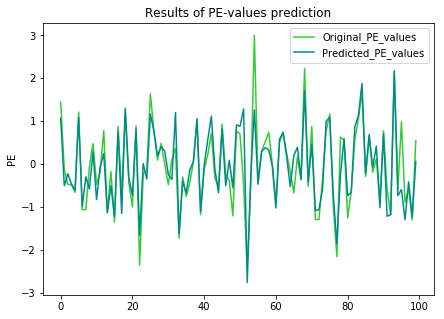

In [141]:
#plot
y_ = list(y_testp26)
plt.figure(figsize=(7,5)) 
plt.plot(y_[0:100], color = 'limegreen', label = 'Original_PE_values')
plt.plot(predp26[0:100], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
#plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [123]:
# EMD pt Ada
yp5 = emd_pt_train2['PE'] # PE
emd_pt_train2_ = emd_pt_train2.drop(['PE'],axis=1)
X_trainp27, X_testp27, y_trainp27, y_testp27 = train_test_split(emd_pt_train2_, yp5, test_size=0.25)
model = AdaBoostRegressor(learning_rate = 1.9000000000000001, n_estimators = 150)
model.fit(X_trainp27,y_trainp27)
predp27 = model.predict(X_testp27)
print (mean_squared_error(y_testp27,predp27))
print (mean_absolute_error(y_testp27,predp27))        
print (r2_score(y_testp27,predp27))

0.336164632713428
0.4666402831731375
0.6492249431536754


In [127]:
# EMD pt KNeighbors 
yp5 = emd_pt_train2['PE'] # PE
emd_pt_train2_ = emd_pt_train2.drop(['PE'],axis=1)
X_trainp28, X_testp28, y_trainp28, y_testp28 = train_test_split(emd_pt_train2_, yp5, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'brute', n_neighbors =  2, weights =  'distance')
model.fit(X_trainp28,y_trainp28)
predp28 = model.predict(X_testp28)
print (mean_squared_error(y_testp28,predp28))
print (mean_absolute_error(y_testp28,predp28))        
print (r2_score(y_testp28,predp28))

0.13682516492843283
0.2240336693225238
0.8473817919003815


In [129]:
# EMD pt L1 
yp5 = emd_pt_train2['PE'] # PE
emd_pt_train2_ = emd_pt_train2.drop(['PE'],axis=1)
X_trainp29, X_testp29, y_trainp29, y_testp29 = train_test_split(emd_pt_train2_, yp5, test_size=0.25)
model = Lasso(alpha = 0.1)
model.fit(X_trainp29,y_trainp29)
predp29 = model.predict(X_testp29)
print (mean_squared_error(y_testp29,predp29))
print (mean_absolute_error(y_testp29,predp29))        
print (r2_score(y_testp29,predp29))

0.5400473295696177
0.5793000523296787
0.44435899090162034


In [133]:
# EMD pt L2 
yp5 = emd_pt_train2['PE'] # PE
emd_pt_train2_ = emd_pt_train2.drop(['PE'],axis=1)
X_trainp30, X_testp30, y_trainp30, y_testp30 = train_test_split(emd_pt_train2_, yp5, test_size=0.25)
model = Ridge(alpha = 0.25000000000000006)
model.fit(X_trainp30,y_trainp30)
predp30 = model.predict(X_testp30)
print (mean_squared_error(y_testp30,predp30))
print (mean_absolute_error(y_testp30,predp30))        
print (r2_score(y_testp30,predp30))

0.31717495660929457
0.42393177611694693
0.682224672990077


In [98]:
# EMD qt RF
yp4 = emd_qt_train2['PE'] # PE
emd_qt_train2_ = emd_qt_train2.drop(['PE'],axis=1)
X_trainp19, X_testp19, y_trainp19, y_testp19 = train_test_split(emd_qt_train2_, yp4, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 300)
model.fit(X_trainp19,y_trainp19)
predp19 = model.predict(X_testp19)
print (mean_squared_error(y_testp19,predp19))
print (mean_absolute_error(y_testp19,predp19))        
print (r2_score(y_testp19,predp19))

0.019650883688618583
0.10781918115375967
0.7610227006580992


In [99]:
# EMD qt XGB
yp4 = emd_qt_train2['PE'] # PE
emd_qt_train2_ = emd_qt_train2.drop(['PE'],axis=1)
X_trainp20, X_testp20, y_trainp20, y_testp20 = train_test_split(emd_qt_train2_, yp4, test_size=0.25)
model = XGBRegressor(max_depth = 7, learning_rate = 0.1, n_estimators = 300)
model.fit(X_trainp20,y_trainp20)
predp20 = model.predict(X_testp20)
print (mean_squared_error(y_testp20,predp20))
print (mean_absolute_error(y_testp20,predp20))        
print (r2_score(y_testp20,predp20))

0.010183956865116233
0.06928863259925629
0.8735966647952904


Text(0, 0.5, 'PE')

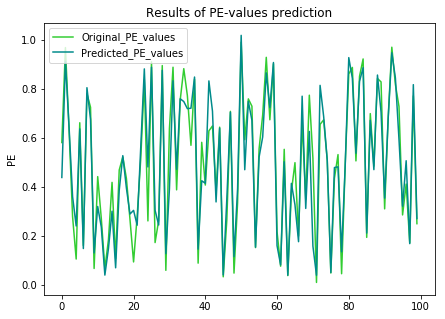

In [140]:
#plot
y_ = list(y_testp20)
plt.figure(figsize=(7,5)) 
plt.plot(y_[0:100], color = 'limegreen', label = 'Original_PE_values')
plt.plot(predp20[0:100], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
#plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [100]:
# EMD qt Ada
yp4 = emd_qt_train2['PE'] # PE
emd_qt_train2_ = emd_qt_train2.drop(['PE'],axis=1)
X_trainp21, X_testp21, y_trainp21, y_testp21 = train_test_split(emd_qt_train2_, yp4, test_size=0.25)
model = AdaBoostRegressor(learning_rate = 0.1, n_estimators = 80)
model.fit(X_trainp21,y_trainp21)
predp21 = model.predict(X_testp21)
print (mean_squared_error(y_testp21,predp21))
print (mean_absolute_error(y_testp21,predp21))        
print (r2_score(y_testp21,predp21))

0.029681733722325215
0.1453256218929327
0.6345107976258074


In [106]:
# EMD qt KNeighbors 
yp4 = emd_qt_train2['PE'] # PE
emd_qt_train2_ = emd_qt_train2.drop(['PE'],axis=1)
X_trainp22, X_testp22, y_trainp22, y_testp22 = train_test_split(emd_qt_train2_, yp4, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'brute', n_neighbors =  4, weights =  'distance')
model.fit(X_trainp22,y_trainp22)
predp22 = model.predict(X_testp22)
print (mean_squared_error(y_testp22,predp22))
print (mean_absolute_error(y_testp22,predp22))        
print (r2_score(y_testp22,predp22))

0.01289122708090724
0.07527310711026394
0.8410643313374613


In [109]:
# EMD qt L1 
yp4 = emd_qt_train2['PE'] # PE
emd_qt_train2_ = emd_qt_train2.drop(['PE'],axis=1)
X_trainp23, X_testp23, y_trainp23, y_testp23 = train_test_split(emd_qt_train2_, yp4, test_size=0.25)
model = Lasso(alpha = 0.1)
model.fit(X_trainp23,y_trainp23)
predp23 = model.predict(X_testp23)
print (mean_squared_error(y_testp23,predp23))
print (mean_absolute_error(y_testp23,predp23))        
print (r2_score(y_testp23,predp23))

0.08334458448130769
0.25038826187592084
-2.3466527212523403e-06


In [113]:
# EMD qt L2 
yp4 = emd_qt_train2['PE'] # PE
emd_qt_train2_ = emd_qt_train2.drop(['PE'],axis=1)
X_trainp24, X_testp24, y_trainp24, y_testp24 = train_test_split(emd_qt_train2_, yp4, test_size=0.25)
model = Ridge(alpha = 0.9500000000000003)
model.fit(X_trainp24,y_trainp24)
predp24 = model.predict(X_testp24)
print (mean_squared_error(y_testp24,predp24))
print (mean_absolute_error(y_testp24,predp24))        
print (r2_score(y_testp24,predp24))

0.026575984900794658
0.127106265681194
0.6870805495058875


In [83]:
# EMD rs RF
yp3 = emd_rs_train2['PE'] # PE
emd_rs_train2_ = emd_rs_train2.drop(['PE'],axis=1)
X_trainp13, X_testp13, y_trainp13, y_testp13 = train_test_split(emd_rs_train2_, yp3, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 50)
model.fit(X_trainp13,y_trainp13)
predp13 = model.predict(X_testp13)
print (mean_squared_error(y_testp13,predp13))
print (mean_absolute_error(y_testp13,predp13))        
print (r2_score(y_testp13,predp13))

0.1484155599130672
0.27954399726018575
0.7439950699351416


In [86]:
# EMD rs XGB
yp3 = emd_rs_train2['PE'] # PE
emd_rs_train2_ = emd_rs_train2.drop(['PE'],axis=1)
X_trainp14, X_testp14, y_trainp14, y_testp14 = train_test_split(emd_rs_train2_, yp3, test_size=0.25)
model = XGBRegressor(max_depth = 7, learning_rate = 0.1, n_estimators = 300)
model.fit(X_trainp14,y_trainp14)
predp14 = model.predict(X_testp14)
print (mean_squared_error(y_testp14,predp14))
print (mean_absolute_error(y_testp14,predp14))        
print (r2_score(y_testp14,predp14))

0.08498186415202212
0.19251848382284864
0.856454098114624


In [87]:
# EMD rs Ada
yp3 = emd_rs_train2['PE'] # PE
emd_rs_train2_ = emd_rs_train2.drop(['PE'],axis=1)
X_trainp15, X_testp15, y_trainp15, y_testp15 = train_test_split(emd_rs_train2_, yp3, test_size=0.25)
model = AdaBoostRegressor(learning_rate = 0.8, n_estimators = 10)
model.fit(X_trainp15,y_trainp15)
predp15 = model.predict(X_testp15)
print (mean_squared_error(y_testp15,predp15))
print (mean_absolute_error(y_testp15,predp15))        
print (r2_score(y_testp15,predp15))

0.19523424685728885
0.344849996550152
0.6252639359075529


In [89]:
# EMD rs KNeighbors 
yp3 = emd_rs_train2['PE'] # PE
emd_rs_train2_ = emd_rs_train2.drop(['PE'],axis=1)
X_trainp16, X_testp16, y_trainp16, y_testp16 = train_test_split(emd_rs_train2_, yp3, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'auto', n_neighbors =  3, weights =  'distance')
model.fit(X_trainp16,y_trainp16)
predp16 = model.predict(X_testp16)
print (mean_squared_error(y_testp16,predp16))
print (mean_absolute_error(y_testp16,predp16))        
print (r2_score(y_testp16,predp16))

0.08683565884724355
0.18377356050164062
0.8430819071620992


In [95]:
# EMD rs L1 
yp3 = emd_rs_train2['PE'] # PE
emd_rs_train2_ = emd_rs_train2.drop(['PE'],axis=1)
X_trainp17, X_testp17, y_trainp17, y_testp17 = train_test_split(emd_rs_train2_, yp3, test_size=0.25)
model = Lasso(alpha = 0.1)
model.fit(X_trainp17,y_trainp17)
predp17 = model.predict(X_testp17)
print (mean_squared_error(y_testp17,predp17))
print (mean_absolute_error(y_testp17,predp17))        
print (r2_score(y_testp17,predp17))

0.32609476358486805
0.44677117002902245
0.3680839093873006


In [97]:
# EMD rs L2 
yp3 = emd_rs_train2['PE'] # PE
emd_rs_train2_ = emd_rs_train2.drop(['PE'],axis=1)
X_trainp18, X_testp18, y_trainp18, y_testp18 = train_test_split(emd_rs_train2_, yp3, test_size=0.25)
model = Ridge(alpha = 0.3500000000000001)
model.fit(X_trainp18,y_trainp18)
predp18 = model.predict(X_testp18)
print (mean_squared_error(y_testp18,predp18))
print (mean_absolute_error(y_testp18,predp18))        
print (r2_score(y_testp18,predp18))

0.2008887491319108
0.3247207178192172
0.6543780544803116


In [81]:
# EMD mm RF
yp2 = emd_mm_train2['PE'] # PE
emd_mm_train2_ = emd_mm_train2.drop(['PE'],axis=1)
X_trainp7, X_testp7, y_trainp7, y_testp7 = train_test_split(emd_mm_train2_, yp2, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 80)
model.fit(X_trainp7,y_trainp7)
predp7 = model.predict(X_testp7)
print (mean_squared_error(y_testp7,predp7))
print (mean_absolute_error(y_testp7,predp7))        
print (r2_score(y_testp7,predp7))

0.0033847163897427583
0.04348666220217052
0.7352780871105098


In [67]:
# EMD mm XGB
yp2 = emd_mm_train2['PE'] # PE
emd_mm_train2_ = emd_mm_train2.drop(['PE'],axis=1)
X_trainp8, X_testp8, y_trainp8, y_testp8 = train_test_split(emd_mm_train2_, yp2, test_size=0.25)
model = XGBRegressor(max_depth = 7, learning_rate = 0.1, n_estimators = 300)
model.fit(X_trainp8,y_trainp8)
predp8 = model.predict(X_testp8)
print (mean_squared_error(y_testp8,predp8))
print (mean_absolute_error(y_testp8,predp8))        
print (r2_score(y_testp8,predp8))

0.001822026882958608
0.029897635547155774
0.8539685927312728


In [65]:
# EMD mm Ada
yp2 = emd_mm_train2['PE'] # PE
emd_mm_train2_ = emd_mm_train2.drop(['PE'],axis=1)
X_trainp9, X_testp9, y_trainp9, y_testp9 = train_test_split(emd_mm_train2_, yp2, test_size=0.25)
model = AdaBoostRegressor(learning_rate = 0.1, n_estimators = 50)
model.fit(X_trainp9,y_trainp9)
predp9 = model.predict(X_testp9)
print (mean_squared_error(y_testp9,predp9))
print (mean_absolute_error(y_testp9,predp9))        
print (r2_score(y_testp9,predp9))

0.004560721112672042
0.05409037079923548
0.5988252565852507


In [76]:
# EMD mm KNeighbors 
yp2 = emd_mm_train2['PE'] # PE
emd_mm_train2_ = emd_mm_train2.drop(['PE'],axis=1)
X_trainp10, X_testp10, y_trainp10, y_testp10 = train_test_split(emd_mm_train2_, yp2, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'auto', n_neighbors =  3, weights =  'distance')
model.fit(X_trainp10,y_trainp10)
predp10 = model.predict(X_testp10)
print (mean_squared_error(y_testp10,predp10))
print (mean_absolute_error(y_testp10,predp10))        
print (r2_score(y_testp10,predp10))

0.0018832570343153387
0.025812291288317683
0.8405583068820804


In [78]:
# EMD mm L1 
yp2 = emd_mm_train2['PE'] # PE
emd_mm_train2_ = emd_mm_train2.drop(['PE'],axis=1)
X_trainp11, X_testp11, y_trainp11, y_testp11 = train_test_split(emd_mm_train2_, yp2, test_size=0.25)
model = Lasso(alpha = 0.1)
model.fit(X_trainp11,y_trainp11)
predp11 = model.predict(X_testp11)
print (mean_squared_error(y_testp11,predp11))
print (mean_absolute_error(y_testp11,predp11))        
print (r2_score(y_testp11,predp11))

0.013086946267049414
0.09001763419788973
-2.1985147999004084e-05


In [80]:
# EMD mm L2 
yp2 = emd_mm_train2['PE'] # PE
emd_mm_train2_ = emd_mm_train2.drop(['PE'],axis=1)
X_trainp12, X_testp12, y_trainp12, y_testp12 = train_test_split(emd_mm_train2_, yp2, test_size=0.25)
model = Ridge(alpha = 0.20000000000000004)
model.fit(X_trainp12,y_trainp12)
predp12 = model.predict(X_testp12)
print (mean_squared_error(y_testp12,predp12))
print (mean_absolute_error(y_testp12,predp12))        
print (r2_score(y_testp12,predp12))

0.00438349633750462
0.04695460932955533
0.6711625353857219


In [51]:
# EMD SS RF
yp1 = emd_ss_train2['PE'] # PE
emd_ss_train2_ = emd_ss_train2.drop(['PE'],axis=1)
X_trainp2, X_testp2, y_trainp2, y_testp2 = train_test_split(emd_ss_train2_, yp1, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 30)
model.fit(X_trainp2,y_trainp2)
predp2 = model.predict(X_testp2)
print (mean_squared_error(y_testp2,predp2))
print (mean_absolute_error(y_testp2,predp2))        
print (r2_score(y_testp2,predp2))

0.28434866749349136
0.38464787423061
0.7303712941766269


In [46]:
# EMD SS XGB
yp1 = emd_ss_train2['PE'] # PE
emd_ss_train2_ = emd_ss_train2.drop(['PE'],axis=1)
X_trainp1, X_testp1, y_trainp1, y_testp1 = train_test_split(emd_ss_train2_, yp1, test_size=0.25)
model = XGBRegressor(max_depth = 6, learning_rate = 0.1, n_estimators = 300)
model.fit(X_trainp1,y_trainp1)
predp1 = model.predict(X_testp1)
print (mean_squared_error(y_testp1,predp1))
print (mean_absolute_error(y_testp1,predp1))        
print (r2_score(y_testp1,predp1))

0.1606724781063337
0.278398073674226
0.8348340424975398


In [55]:
# EMD SS Ada
yp1 = emd_ss_train2['PE'] # PE
emd_ss_train2_ = emd_ss_train2.drop(['PE'],axis=1)
X_trainp3, X_testp3, y_trainp3, y_testp3 = train_test_split(emd_ss_train2_, yp1, test_size=0.25)
model = AdaBoostRegressor(learning_rate = 0.2, n_estimators = 30)
model.fit(X_trainp3,y_trainp3)
predp3 = model.predict(X_testp3)
print (mean_squared_error(y_testp3,predp3))
print (mean_absolute_error(y_testp3,predp3))        
print (r2_score(y_testp3,predp3))

0.3893801256968584
0.48581764134674266
0.6187308117917225


In [57]:
# EMD SS KNeighbors 
yp1 = emd_ss_train2['PE'] # PE
emd_ss_train2_ = emd_ss_train2.drop(['PE'],axis=1)
X_trainp4, X_testp4, y_trainp4, y_testp4 = train_test_split(emd_ss_train2_, yp1, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'brute', n_neighbors =  3, weights =  'distance')
model.fit(X_trainp4,y_trainp4)
predp4 = model.predict(X_testp4)
print (mean_squared_error(y_testp4,predp4))
print (mean_absolute_error(y_testp4,predp4))        
print (r2_score(y_testp4,predp4))

0.20994348785896363
0.25494521491310584
0.8221921232277979


In [60]:
# EMD SS L1 
yp1 = emd_ss_train2['PE'] # PE
emd_ss_train2_ = emd_ss_train2.drop(['PE'],axis=1)
X_trainp6, X_testp6, y_trainp6, y_testp6 = train_test_split(emd_ss_train2_, yp1, test_size=0.25)
model = Lasso(alpha = 0.1)
model.fit(X_trainp6,y_trainp6)
predp6 = model.predict(X_testp6)
print (mean_squared_error(y_testp6,predp6))
print (mean_absolute_error(y_testp6,predp6))        
print (r2_score(y_testp6,predp6))

0.6224815078198774
0.5903229851090958
0.3569236904764197


In [58]:
# EMD SS L2 
yp1 = emd_ss_train2['PE'] # PE
emd_ss_train2_ = emd_ss_train2.drop(['PE'],axis=1)
X_trainp5, X_testp5, y_trainp5, y_testp5 = train_test_split(emd_ss_train2_, yp1, test_size=0.25)
model = Ridge(alpha = 0.8000000000000002)
model.fit(X_trainp5,y_trainp5)
predp5 = model.predict(X_testp5)
print (mean_squared_error(y_testp5,predp5))
print (mean_absolute_error(y_testp5,predp5))        
print (r2_score(y_testp5,predp5))

0.36154322288280294
0.4256891331973612
0.6684720134395372


In [31]:
fit_best_estimator(eemd_ss_train2,eemd_ss_test2,'EEMD, StandardScale')
fit_best_estimator(eemd_mm_train2,eemd_mm_test2,'EEMD, MinMaxScale')
fit_best_estimator(eemd_qt_train2,eemd_qt_test2,'EEMD, QuantileTransform')
fit_best_estimator(eemd_rs_train2,eemd_rs_test2,'EEMD, RobustScale')                            
fit_best_estimator(eemd_pt_train2,eemd_pt_test2,'EEMD, PowerTransform')

Now its EEMD, StandardScale noise and preprocessing types
RF

Params are:{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 80}
MSE-0.3007740715897725
XGB

Params are:{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150}
MSE-0.25142509865671286
Ada

Params are:{'learning_rate': 0.1, 'n_estimators': 50}
MSE-0.388126518852181
KNeighbors

Params are:{'algorithm': 'brute', 'n_neighbors': 14, 'weights': 'distance'}
MSE-0.28106768895804074
L1 regularized linear

Params are:{'alpha': 0.1}
MSE-0.6413241050604396
L2 regularized linear

Params are:{'alpha': 0.9500000000000003}
MSE-0.35230479389115377
For model RF MSE score is: 0.2958336804395112
For model RF MAE score is: 0.3905502357417455
For model RF R2 score is: 0.7044141745974354
For model XGB MSE score is: 0.23047366377277134
For model XGB MAE score is: 0.33932603353510027
For model XGB R2 score is: 0.7697194314095106
For model Ada MSE score is: 0.4181597391706686
For model Ada MAE score is: 0.5050970284685729
For model Ada R2 

In [102]:
# EEMD pt RF
yp5 = eemd_pt_train2['PE'] # PE
eemd_pt_train2_ = eemd_pt_train2.drop(['PE'],axis=1)
X_trainp25, X_testp25, y_trainp25, y_testp25 = train_test_split(eemd_pt_train2_, yp5, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 300)
model.fit(X_trainp25,y_trainp25)
predp25 = model.predict(X_testp25)
print (mean_squared_error(y_testp25,predp25))
print (mean_absolute_error(y_testp25,predp25))        
print (r2_score(y_testp25,predp25))

0.23936689961645846
0.37340341112220754
0.7279779915053637


In [107]:
# EEMD pt XGB
yp5 = eemd_pt_train2['PE'] # PE
eemd_pt_train2_ = eemd_pt_train2.drop(['PE'],axis=1)
X_trainp26, X_testp26, y_trainp26, y_testp26 = train_test_split(eemd_pt_train2_, yp5, test_size=0.25)
model = XGBRegressor(max_depth = 6, learning_rate = 0.1, n_estimators = 100)
model.fit(X_trainp26,y_trainp26)
predp26 = model.predict(X_testp26)
print (mean_squared_error(y_testp26,predp26))
print (mean_absolute_error(y_testp26,predp26))        
print (r2_score(y_testp26,predp26))

0.1900524121551969
0.3180121331272205
0.8004780735871626


Text(0, 0.5, 'PE')

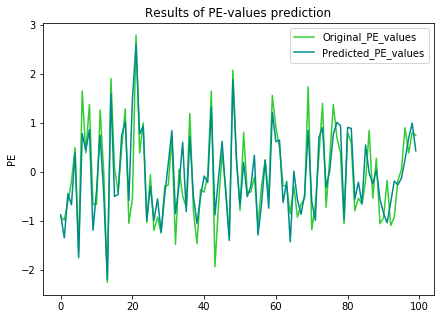

In [122]:
#plot
y_ = list(y_testp26)
plt.figure(figsize=(7,5)) 
plt.plot(y_[0:100], color = 'limegreen', label = 'Original_PE_values')
plt.plot(predp26[0:100], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
#plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [111]:
# EEMD pt Ada
yp5 = eemd_pt_train2['PE'] # PE
eemd_pt_train2_ = eemd_pt_train2.drop(['PE'],axis=1)
X_trainp27, X_testp27, y_trainp27, y_testp27 = train_test_split(eemd_pt_train2_, yp5, test_size=0.25)
model = AdaBoostRegressor(learning_rate = 0.2, n_estimators = 50)
model.fit(X_trainp27,y_trainp27)
predp27 = model.predict(X_testp27)
print (mean_squared_error(y_testp27,predp27))
print (mean_absolute_error(y_testp27,predp27))        
print (r2_score(y_testp27,predp27))

0.38322460861333274
0.4755918193730262
0.6171331145440497


In [113]:
# EEMD pt KNeighbors 
yp5 = eemd_pt_train2['PE'] # PE
eemd_pt_train2_ = eemd_pt_train2.drop(['PE'],axis=1)
X_trainp28, X_testp28, y_trainp28, y_testp28 = train_test_split(eemd_pt_train2_, yp5, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'auto', n_neighbors =  9, weights =  'distance')
model.fit(X_trainp28,y_trainp28)
predp28 = model.predict(X_testp28)
print (mean_squared_error(y_testp28,predp28))
print (mean_absolute_error(y_testp28,predp28))        
print (r2_score(y_testp28,predp28))

0.22257538666727766
0.3397601956027233
0.7643011579944348


In [114]:
# EEMD pt L1 
yp5 = eemd_pt_train2['PE'] # PE
eemd_pt_train2_ = eemd_pt_train2.drop(['PE'],axis=1)
X_trainp29, X_testp29, y_trainp29, y_testp29 = train_test_split(eemd_pt_train2_, yp5, test_size=0.25)
model = Lasso(alpha = 0.1)
model.fit(X_trainp29,y_trainp29)
predp29 = model.predict(X_testp29)
print (mean_squared_error(y_testp29,predp29))
print (mean_absolute_error(y_testp29,predp29))        
print (r2_score(y_testp29,predp29))

0.5405174614563456
0.5620373076714285
0.4368876918940908


In [120]:
# EEMD pt L2 
yp5 = eemd_pt_train2['PE'] # PE
eemd_pt_train2_ = eemd_pt_train2.drop(['PE'],axis=1)
X_trainp30, X_testp30, y_trainp30, y_testp30 = train_test_split(eemd_pt_train2_, yp5, test_size=0.25)
model = Ridge(alpha =  0.9500000000000003)
model.fit(X_trainp30,y_trainp30)
predp30 = model.predict(X_testp30)
print (mean_squared_error(y_testp30,predp30))
print (mean_absolute_error(y_testp30,predp30))        
print (r2_score(y_testp30,predp30))

0.31616435297345014
0.42774997983776997
0.664408185835708


In [88]:
# EEMD qt RF
yp4 = eemd_qt_train2['PE'] # PE
eemd_qt_train2_ = eemd_qt_train2.drop(['PE'],axis=1)
X_trainp19, X_testp19, y_trainp19, y_testp19 = train_test_split(eemd_qt_train2_, yp4, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 150)
model.fit(X_trainp19,y_trainp19)
predp19 = model.predict(X_testp19)
print (mean_squared_error(y_testp19,predp19))
print (mean_absolute_error(y_testp19,predp19))        
print (r2_score(y_testp19,predp19))

0.02152197364594621
0.11521570290206773
0.7489042542728259


In [91]:
# EEMD qt XGB
yp4 = eemd_qt_train2['PE'] # PE
eemd_qt_train2_ = eemd_qt_train2.drop(['PE'],axis=1)
X_trainp20, X_testp20, y_trainp20, y_testp20 = train_test_split(eemd_qt_train2_, yp4, test_size=0.25)
model = XGBRegressor(max_depth = 7, learning_rate = 0.1, n_estimators = 100)
model.fit(X_trainp20,y_trainp20)
predp20 = model.predict(X_testp20)
print (mean_squared_error(y_testp20,predp20))
print (mean_absolute_error(y_testp20,predp20))        
print (r2_score(y_testp20,predp20))

0.01789265522653776
0.0995064817190516
0.790567919497229


Text(0, 0.5, 'PE')

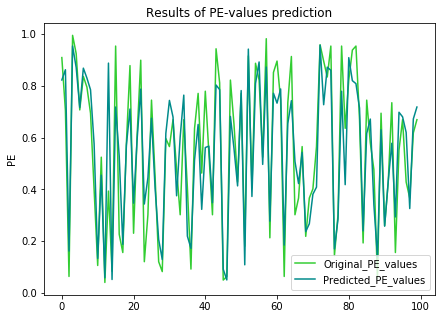

In [121]:
#plot
y_ = list(y_testp20)
plt.figure(figsize=(7,5)) 
plt.plot(y_[0:100], color = 'limegreen', label = 'Original_PE_values')
plt.plot(predp20[0:100], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
#plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [92]:
# EEMD qt Ada
yp4 = eemd_qt_train2['PE'] # PE
eemd_qt_train2_ = eemd_qt_train2.drop(['PE'],axis=1)
X_trainp21, X_testp21, y_trainp21, y_testp21 = train_test_split(eemd_qt_train2_, yp4, test_size=0.25)
model = AdaBoostRegressor(learning_rate = 0.1, n_estimators = 100)
model.fit(X_trainp21,y_trainp21)
predp21 = model.predict(X_testp21)
print (mean_squared_error(y_testp21,predp21))
print (mean_absolute_error(y_testp21,predp21))        
print (r2_score(y_testp21,predp21))

0.029217951751151973
0.14379448791312865
0.6472901715133378


In [94]:
# EEMD qt KNeighbors 
yp4 = eemd_qt_train2['PE'] # PE
eemd_qt_train2_ = eemd_qt_train2.drop(['PE'],axis=1)
X_trainp22, X_testp22, y_trainp22, y_testp22 = train_test_split(eemd_qt_train2_, yp4, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'brute', n_neighbors =  16, weights =  'distance')
model.fit(X_trainp22,y_trainp22)
predp22 = model.predict(X_testp22)
print (mean_squared_error(y_testp22,predp22))
print (mean_absolute_error(y_testp22,predp22))        
print (r2_score(y_testp22,predp22))

0.021777310636348527
0.11044501131336512
0.7435404721833365


In [96]:
# EEMD qt L1 
yp4 = eemd_qt_train2['PE'] # PE
eemd_qt_train2_ = eemd_qt_train2.drop(['PE'],axis=1)
X_trainp23, X_testp23, y_trainp23, y_testp23 = train_test_split(eemd_qt_train2_, yp4, test_size=0.25)
model = Lasso(alpha = 0.1)
model.fit(X_trainp23,y_trainp23)
predp23 = model.predict(X_testp23)
print (mean_squared_error(y_testp23,predp23))
print (mean_absolute_error(y_testp23,predp23))        
print (r2_score(y_testp23,predp23))

0.0862810633088515
0.2553113294563883
-0.00011570936518645603


In [98]:
# EEMD qt L2 
yp4 = eemd_qt_train2['PE'] # PE
eemd_qt_train2_ = eemd_qt_train2.drop(['PE'],axis=1)
X_trainp24, X_testp24, y_trainp24, y_testp24 = train_test_split(eemd_qt_train2_, yp4, test_size=0.25)
model = Ridge(alpha = 0.7500000000000002)
model.fit(X_trainp24,y_trainp24)
predp24 = model.predict(X_testp24)
print (mean_squared_error(y_testp24,predp24))
print (mean_absolute_error(y_testp24,predp24))        
print (r2_score(y_testp24,predp24))

0.026628144814835823
0.12916834629763285
0.6802131936864548


In [67]:
# EEMD rs RF
yp3 = eemd_rs_train2['PE'] # PE
eemd_rs_train2_ = eemd_rs_train2.drop(['PE'],axis=1)
X_trainp13, X_testp13, y_trainp13, y_testp13 = train_test_split(eemd_rs_train2_, yp3, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 200)
model.fit(X_trainp13,y_trainp13)
predp13 = model.predict(X_testp13)
print (mean_squared_error(y_testp13,predp13))
print (mean_absolute_error(y_testp13,predp13))        
print (r2_score(y_testp13,predp13))

0.1468716321004565
0.2929591004053676
0.7315409676283441


In [71]:
# EEMD rs XGB
yp3 = eemd_rs_train2['PE'] # PE
eemd_rs_train2_ = eemd_rs_train2.drop(['PE'],axis=1)
X_trainp14, X_testp14, y_trainp14, y_testp14 = train_test_split(eemd_rs_train2_, yp3, test_size=0.25)
model = XGBRegressor(max_depth = 5, learning_rate = 0.1, n_estimators = 150)
model.fit(X_trainp14,y_trainp14)
predp14 = model.predict(X_testp14)
print (mean_squared_error(y_testp14,predp14))
print (mean_absolute_error(y_testp14,predp14))        
print (r2_score(y_testp14,predp14))

0.1358340054286913
0.2627579753661511
0.7705191910487188


In [72]:
# EEMD rs Ada
yp3 = eemd_rs_train2['PE'] # PE
eemd_rs_train2_ = eemd_rs_train2.drop(['PE'],axis=1)
X_trainp15, X_testp15, y_trainp15, y_testp15 = train_test_split(eemd_rs_train2_, yp3, test_size=0.25)
model = AdaBoostRegressor(learning_rate =  0.30000000000000004, n_estimators = 20)
model.fit(X_trainp15,y_trainp15)
predp15 = model.predict(X_testp15)
print (mean_squared_error(y_testp15,predp15))
print (mean_absolute_error(y_testp15,predp15))        
print (r2_score(y_testp15,predp15))

0.18540548624574923
0.33582720272911276
0.6267083628344856


In [74]:
# EEMD rs KNeighbors 
yp3 = eemd_rs_train2['PE'] # PE
eemd_rs_train2_ = eemd_rs_train2.drop(['PE'],axis=1)
X_trainp16, X_testp16, y_trainp16, y_testp16 = train_test_split(eemd_rs_train2_, yp3, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'brute', n_neighbors =  12, weights =  'distance')
model.fit(X_trainp16,y_trainp16)
predp16 = model.predict(X_testp16)
print (mean_squared_error(y_testp16,predp16))
print (mean_absolute_error(y_testp16,predp16))        
print (r2_score(y_testp16,predp16))

0.16081982401086964
0.2835336278001379
0.7222945380835564


In [85]:
# EEMD rs L1 
yp3 = eemd_rs_train2['PE'] # PE
eemd_rs_train2_ = eemd_rs_train2.drop(['PE'],axis=1)
X_trainp17, X_testp17, y_trainp17, y_testp17 = train_test_split(eemd_rs_train2_, yp3, test_size=0.25)
model = Lasso(alpha = 0.1)
model.fit(X_trainp17,y_trainp17)
predp17 = model.predict(X_testp17)
print (mean_squared_error(y_testp17,predp17))
print (mean_absolute_error(y_testp17,predp17))        
print (r2_score(y_testp17,predp17))

0.39520992798046845
0.47141303163810144
0.32805226764868234


In [86]:
# EEMD rs L2 
yp3 = eemd_rs_train2['PE'] # PE
eemd_rs_train2_ = eemd_rs_train2.drop(['PE'],axis=1)
X_trainp18, X_testp18, y_trainp18, y_testp18 = train_test_split(eemd_rs_train2_, yp3, test_size=0.25)
model = Ridge(alpha = 0.7500000000000002)
model.fit(X_trainp18,y_trainp18)
predp18 = model.predict(X_testp18)
print (mean_squared_error(y_testp18,predp18))
print (mean_absolute_error(y_testp18,predp18))        
print (r2_score(y_testp18,predp18))

0.1767840793004699
0.3139146732362256
0.6757181132915987


In [48]:
# EEMD mm RF
yp2 = eemd_mm_train2['PE'] # PE
eemd_mm_train2_ = eemd_mm_train2.drop(['PE'],axis=1)
X_trainp7, X_testp7, y_trainp7, y_testp7 = train_test_split(eemd_mm_train2_, yp2, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 300)
model.fit(X_trainp7,y_trainp7)
predp7 = model.predict(X_testp7)
print (mean_squared_error(y_testp7,predp7))
print (mean_absolute_error(y_testp7,predp7))        
print (r2_score(y_testp7,predp7))

0.0037491525331620887
0.04624155802913576
0.7202898822797205


In [50]:
# EEMD mm XGB
yp2 = eemd_mm_train2['PE'] # PE
eemd_mm_train2_ = eemd_mm_train2.drop(['PE'],axis=1)
X_trainp8, X_testp8, y_trainp8, y_testp8 = train_test_split(eemd_mm_train2_, yp2, test_size=0.25)
model = XGBRegressor(max_depth = 5, learning_rate = 0.1, n_estimators = 200)
model.fit(X_trainp8,y_trainp8)
predp8 = model.predict(X_testp8)
print (mean_squared_error(y_testp8,predp8))
print (mean_absolute_error(y_testp8,predp8))        
print (r2_score(y_testp8,predp8))

0.002849962945762463
0.03886998641369812
0.7742214775980629


In [52]:
# EEMD mm Ada
yp2 = eemd_mm_train2['PE'] # PE
eemd_mm_train2_ = eemd_mm_train2.drop(['PE'],axis=1)
X_trainp9, X_testp9, y_trainp9, y_testp9 = train_test_split(eemd_mm_train2_, yp2, test_size=0.25)
model = AdaBoostRegressor(learning_rate =  0.30000000000000004, n_estimators = 20)
model.fit(X_trainp9,y_trainp9)
predp9 = model.predict(X_testp9)
print (mean_squared_error(y_testp9,predp9))
print (mean_absolute_error(y_testp9,predp9))        
print (r2_score(y_testp9,predp9))

0.005197312162451654
0.056411849234927064
0.6049642722655473


In [63]:
# EEMD mm KNeighbors 
yp2 = eemd_mm_train2['PE'] # PE
eemd_mm_train2_ = eemd_mm_train2.drop(['PE'],axis=1)
X_trainp10, X_testp10, y_trainp10, y_testp10 = train_test_split(eemd_mm_train2_, yp2, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'brute', n_neighbors =  13, weights =  'distance')
model.fit(X_trainp10,y_trainp10)
predp10 = model.predict(X_testp10)
print (mean_squared_error(y_testp10,predp10))
print (mean_absolute_error(y_testp10,predp10))        
print (r2_score(y_testp10,predp10))

0.0040653393136900265
0.04461423313379329
0.7184631029387216


In [57]:
# EEMD mm L1 
yp2 = eemd_mm_train2['PE'] # PE
eemd_mm_train2_ = eemd_mm_train2.drop(['PE'],axis=1)
X_trainp11, X_testp11, y_trainp11, y_testp11 = train_test_split(eemd_mm_train2_, yp2, test_size=0.25)
model = Lasso(alpha = 0.1)
model.fit(X_trainp11,y_trainp11)
predp11 = model.predict(X_testp11)
print (mean_squared_error(y_testp11,predp11))
print (mean_absolute_error(y_testp11,predp11))        
print (r2_score(y_testp11,predp11))

0.012825202850861958
0.08856048599548863
-0.0001484729404372942


In [64]:
# EEMD mm L2 
yp2 = eemd_mm_train2['PE'] # PE
eemd_mm_train2_ = eemd_mm_train2.drop(['PE'],axis=1)
X_trainp12, X_testp12, y_trainp12, y_testp12 = train_test_split(eemd_mm_train2_, yp2, test_size=0.25)
model = Ridge(alpha = 0.1)
model.fit(X_trainp12,y_trainp12)
predp12 = model.predict(X_testp12)
print (mean_squared_error(y_testp12,predp12))
print (mean_absolute_error(y_testp12,predp12))        
print (r2_score(y_testp12,predp12))

0.0050056793078005965
0.05076531245565383
0.6177857210175867


In [33]:
# EEMD SS RF
yp1 = eemd_ss_train2['PE'] # PE
eemd_ss_train2_ = eemd_ss_train2.drop(['PE'],axis=1)
X_trainp2, X_testp2, y_trainp2, y_testp2 = train_test_split(eemd_ss_train2_, yp1, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 80)
model.fit(X_trainp2,y_trainp2)
predp2 = model.predict(X_testp2)
print (mean_squared_error(y_testp2,predp2))
print (mean_absolute_error(y_testp2,predp2))        
print (r2_score(y_testp2,predp2))

0.2576282318414524
0.37522018714774497
0.7263420373490509


In [35]:
# EEMD SS XGB
yp1 = eemd_ss_train2['PE'] # PE
eemd_ss_train2_ = eemd_ss_train2.drop(['PE'],axis=1)
X_trainp1, X_testp1, y_trainp1, y_testp1 = train_test_split(eemd_ss_train2_, yp1, test_size=0.25)
model = XGBRegressor(max_depth = 6, learning_rate = 0.1, n_estimators = 150)
model.fit(X_trainp1,y_trainp1)
predp1 = model.predict(X_testp1)
print (mean_squared_error(y_testp1,predp1))
print (mean_absolute_error(y_testp1,predp1))        
print (r2_score(y_testp1,predp1))

0.2285857384642609
0.34107515024791796
0.778525491038455


In [38]:
# EEMD SS Ada
yp1 = eemd_ss_train2['PE'] # PE
eemd_ss_train2_ = eemd_ss_train2.drop(['PE'],axis=1)
X_trainp3, X_testp3, y_trainp3, y_testp3 = train_test_split(eemd_ss_train2_, yp1, test_size=0.25)
model = AdaBoostRegressor(learning_rate = 0.1, n_estimators = 50)
model.fit(X_trainp3,y_trainp3)
predp3 = model.predict(X_testp3)
print (mean_squared_error(y_testp3,predp3))
print (mean_absolute_error(y_testp3,predp3))        
print (r2_score(y_testp3,predp3))

0.4095446666569247
0.5010864535756971
0.6085533955487794


In [40]:
# EEMD SS KNeighbors 
yp1 = eemd_ss_train2['PE'] # PE
eemd_ss_train2_ = eemd_ss_train2.drop(['PE'],axis=1)
X_trainp4, X_testp4, y_trainp4, y_testp4 = train_test_split(eemd_ss_train2_, yp1, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'brute', n_neighbors =  14, weights =  'distance')
model.fit(X_trainp4,y_trainp4)
predp4 = model.predict(X_testp4)
print (mean_squared_error(y_testp4,predp4))
print (mean_absolute_error(y_testp4,predp4))        
print (r2_score(y_testp4,predp4))

0.26842645851292984
0.37007202161636826
0.7431101973243456


In [42]:
# EEMD SS L1 
yp1 = eemd_ss_train2['PE'] # PE
eemd_ss_train2_ = eemd_ss_train2.drop(['PE'],axis=1)
X_trainp6, X_testp6, y_trainp6, y_testp6 = train_test_split(eemd_ss_train2_, yp1, test_size=0.25)
model = Lasso(alpha = 0.1)
model.fit(X_trainp6,y_trainp6)
predp6 = model.predict(X_testp6)
print (mean_squared_error(y_testp6,predp6))
print (mean_absolute_error(y_testp6,predp6))        
print (r2_score(y_testp6,predp6))

0.6429819645311216
0.6197673924070893
0.36773634827317336


In [44]:
# EEMD SS L2 
yp1 = eemd_ss_train2['PE'] # PE
eemd_ss_train2_ = eemd_ss_train2.drop(['PE'],axis=1)
X_trainp5, X_testp5, y_trainp5, y_testp5 = train_test_split(eemd_ss_train2_, yp1, test_size=0.25)
model = Ridge(alpha = 0.9500000000000003)
model.fit(X_trainp5,y_trainp5)
predp5 = model.predict(X_testp5)
print (mean_squared_error(y_testp5,predp5))
print (mean_absolute_error(y_testp5,predp5))        
print (r2_score(y_testp5,predp5))

0.3622489206712501
0.42674668736992616
0.6405477852920585


In [ ]:
fit_best_estimator(emd_ss_train,emd_ss_test,'EMD, StandardScale')
fit_best_estimator(emd_mm_train,emd_mm_test,'EMD, MinMaxScale')
fit_best_estimator(emd_qt_train,emd_qt_test,'EMD, QuantileTransform')
fit_best_estimator(emd_rs_train,emd_rs_test,'EMD, RobustScale')                            
fit_best_estimator(emd_pt_train,emd_pt_test,'EMD, PowerTransform')

In [150]:
fit_best_estimator(emd_ss_train,emd_ss_test,'EMD, StandardScale')
fit_best_estimator(emd_mm_train,emd_mm_test,'EMD, MinMaxScale')
fit_best_estimator(emd_qt_train,emd_qt_test,'EMD, QuantileTransform')
fit_best_estimator(emd_rs_train,emd_rs_test,'EMD, RobustScale')                            
fit_best_estimator(emd_pt_train,emd_pt_test,'EMD, PowerTransform')

Now its EMD, StandardScale noise and preprocessing types
RF

Params are:{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 80}
MSE-0.0007779362016998311
XGB

Params are:{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
MSE-0.0003983852876427712
Ada

Params are:{'learning_rate': 1.9000000000000001, 'n_estimators': 200}
MSE-0.006920781259016772
KNeighbors

Params are:{'algorithm': 'brute', 'n_neighbors': 2, 'weights': 'distance'}
MSE-0.0004087095344396254
L1 regularized linear

Params are:{'alpha': 0.1}
MSE-0.09194786294001742
L2 regularized linear

Params are:{'alpha': 0.9500000000000003}
MSE-0.061859954580535385
For model RF MSE score is: 0.00046999584812433315
For model RF MAE score is: 0.00816287306204393
For model RF R2 score is: 0.9995229783944989
For model XGB MSE score is: 0.0001409660320297954
For model XGB MAE score is: 0.002693751295005262
For model XGB R2 score is: 0.9998569267299098
For model Ada MSE score is: 0.010523173875940723
For model Ada MAE score is: 

In [151]:
fit_best_estimator(eemd_ss_train,eemd_ss_test,'EEMD, StandardScale')
fit_best_estimator(eemd_mm_train,eemd_mm_test,'EEMD, MinMaxScale')
fit_best_estimator(eemd_qt_train,eemd_qt_test,'EEMD, QuantileTransform')
fit_best_estimator(eemd_rs_train,eemd_rs_test,'EEMD, RobustScale')
fit_best_estimator(eemd_pt_train,eemd_pt_test,'EEMD, PowerTransform')

Now its EEMD, StandardScale noise and preprocessing types
RF

Params are:{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}
MSE-0.001502977017281825
XGB

Params are:{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
MSE-0.0005492351921669267
Ada

Params are:{'learning_rate': 0.6, 'n_estimators': 80}
MSE-0.008213999429911975
KNeighbors

Params are:{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
MSE-0.000536387914985572
L1 regularized linear

Params are:{'alpha': 0.1}
MSE-0.08678948159465259
L2 regularized linear

Params are:{'alpha': 0.9500000000000003}
MSE-0.06124635016096956
For model RF MSE score is: 0.00039492976311705715
For model RF MAE score is: 0.007515538758817339
For model RF R2 score is: 0.9996031831963166
For model XGB MSE score is: 0.00042321102818344505
For model XGB MAE score is: 0.0033216134949688634
For model XGB R2 score is: 0.999574766798628
For model Ada MSE score is: 0.01011914607400136
For model Ada MAE score is: 0.076797484128304

In [152]:
fit_best_estimator(ceemd_ss_train,ceemd_ss_test,'CEEMD, StandardScale')
fit_best_estimator(ceemd_mm_train,ceemd_mm_test,'CEEMD, MinMaxScale')
fit_best_estimator(ceemd_qt_train,ceemd_qt_test,'CEEMD, QuantileTransform')
fit_best_estimator(ceemd_rs_train,ceemd_rs_test,'CEEMD, RobustScale')
fit_best_estimator(ceemd_pt_train,ceemd_pt_test,'CEEMD, PowerTransform')

Now its CEEMD, StandardScale noise and preprocessing types
RF

Params are:{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 300}
MSE-0.0012609926088707729
XGB

Params are:{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
MSE-0.00048242216380816444
Ada

Params are:{'learning_rate': 0.8, 'n_estimators': 300}
MSE-0.00881495643903575
KNeighbors

Params are:{'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'distance'}
MSE-0.0005152122857059639
L1 regularized linear

Params are:{'alpha': 0.15000000000000002}
MSE-0.08468410861809446
L2 regularized linear

Params are:{'alpha': 0.9500000000000003}
MSE-0.05964221383865946
For model RF MSE score is: 0.00021961317801738307
For model RF MAE score is: 0.00694846126929326
For model RF R2 score is: 0.9997928439348269
For model XGB MSE score is: 0.0003254175466317755
For model XGB MAE score is: 0.002977358601744537
For model XGB R2 score is: 0.9996930411047865
For model Ada MSE score is: 0.00877772440715099
For model Ada MAE score is:

In [90]:
# Берём EEMD + PowerTransform(yeo-johnson) + XGB (самый высокий и СТАБИЛЬНЫЙ результат + yeo-johnson поправляет распределение)
#eemd_pt_train,eemd_pt_test
#Params are:{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 150}

y = eemd_pt_train['3'] # PE
eemd_pt_train_ = eemd_pt_train.drop(['3'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(eemd_pt_train_, y, test_size=0.25)
model = XGBRegressor(learning_rate = 0.1, max_depth = 6, n_estimators = 150)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print (mean_squared_error(y_test,pred))
print (mean_absolute_error(y_test,pred))        
print (r2_score(y_test,pred))
    

0.1711825169383728
0.3214603856545943
0.8252958888695795


Text(0, 0.5, 'PE')

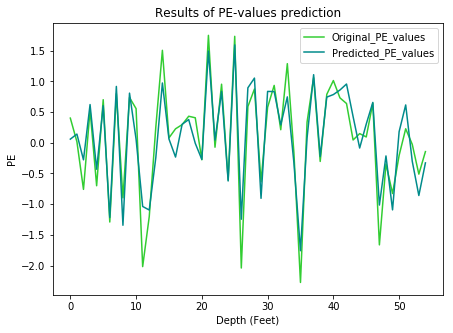

In [335]:
y_ = list(y_test)
plt.figure(figsize=(7,5))
plt.plot(y_[0:55], color = 'limegreen', label = 'Original_PE_values')
plt.plot(pred[0:55], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [155]:
y = eemd_pt_train['3'] # PE
eemd_pt_train_ = eemd_pt_train.drop(['3'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(eemd_pt_train_, y, test_size=0.25)
model = XGBRegressor(max_depth = 6, max_features = 'auto', n_estimators = 150)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print (mean_squared_error(y_test,pred))
print (mean_absolute_error(y_test,pred))        
print (r2_score(y_test,pred))

0.1543031665401161
0.3044612628772977
0.8451427232525737


Text(0, 0.5, 'PE')

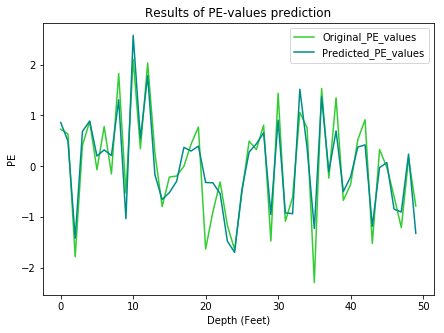

In [159]:
y_ee = list(y_test)
plt.figure(figsize=(7,5))
plt.plot(y_ee[40:90], color = 'limegreen', label = 'Original_PE_values')
plt.plot(pred[40:90], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [121]:
y = eemd_qt_train['3'] # PE
eemd_qt_train_ = eemd_qt_train.drop(['3'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(eemd_qt_train_, y, test_size=0.25)
model = XGBRegressor(max_depth = 6, max_features = 'auto', n_estimators = 300)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print (mean_squared_error(y_test,pred))
print (mean_absolute_error(y_test,pred))        
print (r2_score(y_test,pred))

0.01179265469123841
0.08359521333068383
0.8579537951634175


Text(0, 0.5, 'PE')

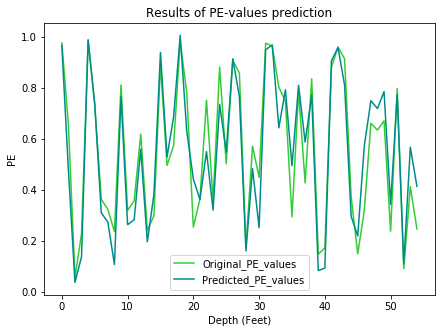

In [122]:
y_ = list(y_test)
plt.figure(figsize=(7,5))
plt.plot(y_[0:55], color = 'limegreen', label = 'Original_PE_values')
plt.plot(pred[0:55], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [123]:
y_

[0.9754345077910908,
 0.6559687442441138,
 0.055061411158890496,
 0.2272144900394959,
 0.9861842531986064,
 0.7319731578995909,
 0.36231781413094816,
 0.3221487014427612,
 0.2351872534701637,
 0.8103091869858687,
 0.3182788850802733,
 0.35601258702822897,
 0.6176282359228058,
 0.2402406360041126,
 0.2972716745622422,
 0.8907455677682388,
 0.4944467597175005,
 0.5725334541704913,
 0.9815408571147604,
 0.7797087962069637,
 0.25288555478945496,
 0.3626804068659636,
 0.7497913426358505,
 0.35912488870817266,
 0.8810049276830046,
 0.5009168816143161,
 0.9060452935542708,
 0.8578411168364709,
 0.17382965585680188,
 0.5705278382171672,
 0.4474471593997955,
 0.973970664212358,
 0.9629906521378168,
 0.8021475921924517,
 0.7466908300865912,
 0.29291357249261857,
 0.7851723343856569,
 0.4261889871468991,
 0.8345457743083652,
 0.1464716066973974,
 0.17115722718833273,
 0.8793696791163405,
 0.958968320068673,
 0.9129187659980238,
 0.3711833825193972,
 0.14823662070954954,
 0.3188187869872191,
 0.65

In [134]:
y = emd_qt_train['3'] # PE
emd_qt_train_ = emd_qt_train.drop(['3'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(emd_qt_train_, y, test_size=0.25)
model = XGBRegressor(max_depth = 6, max_features = 'auto', n_estimators = 300)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print (mean_squared_error(y_test,pred))
print (mean_absolute_error(y_test,pred))        
print (r2_score(y_test,pred))

0.012423762715788988
0.08566692640294965
0.8533088632250863


Text(0, 0.5, 'PE')

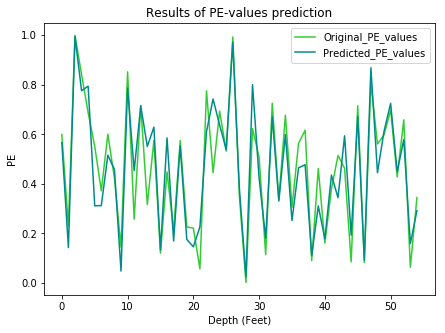

In [135]:
y1 = list(y_test)
plt.figure(figsize=(7,5))
plt.plot(y1[0:55], color = 'limegreen', label = 'Original_PE_values')
plt.plot(pred[0:55], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [137]:
y = emd_qt_train['3'] # PE
emd_qt_train_ = emd_qt_train.drop(['3'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(emd_qt_train_, y, test_size=0.25)
model = XGBRegressor(max_depth = 6, max_features = 'auto', n_estimators = 300)
model.fit(X_train,y_train)
pred1 = model.predict(X_test)
print (mean_squared_error(y_test,pred1))
print (mean_absolute_error(y_test,pred1))        
print (r2_score(y_test,pred))

0.013343167887169858
0.08897451753220732
-0.8747070597768076


Text(0, 0.5, 'PE')

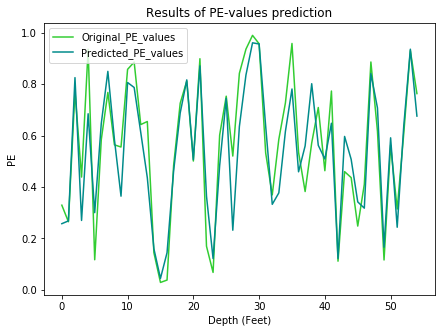

In [138]:
y2 = list(y_test)
plt.figure(figsize=(7,5))
plt.plot(y2[0:55], color = 'limegreen', label = 'Original_PE_values')
plt.plot(pred1[0:55], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

### <font color = "blue"> DATA VISUALIZATION (The logging diagram for well) </font>

In [6]:
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
good_data = pd.read_csv('data_good_ready.csv',encoding = 'utf-8')
facies_data = pd.read_csv('facies_data.csv',encoding = 'utf-8')

In [7]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as FF
plotly.tools.set_credentials_file(username='*', api_key='*')

In [8]:
tb1 = FF.create_table(facies_data[5:16])#.head(10))
py.iplot(tb1,filename='facies_table')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~july_789/0 or inside your plot.ly account where it is named 'facies_table'


In [59]:
tb2 = FF.create_table(good_data[5:16])
py.iplot(tb2, filename='good_facies_table')

In [9]:
facies_colors = ['#F56F45', '#FA7E7E','#8C8456','#8F6A9E',
       '#226854','#9EDAAB', '#7C97FC', '#25C4EF', '#A7D909'] 

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
facies_color_map = {}
for i, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[i]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

In [10]:
good_data.loc[:,'Label'] = good_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
facies_data.loc[:,'Label'] = facies_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [11]:
def make_facies_log_plot(logs, facies_colors):
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-g')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='black')
    ax[4].plot(logs.PE, logs.Depth, '-', color='r')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

### <font color = "blue"> Before data transform for well SHRIMPLIN</font>

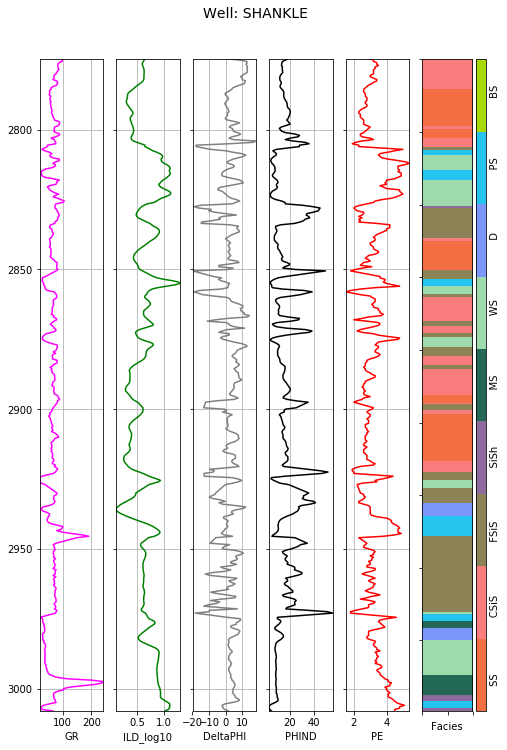

In [12]:
make_facies_log_plot(
    facies_data[facies_data['Well Name'] == 'SHANKLE'],
    facies_colors)

In [290]:
EEMD_data21 = pd.read_csv('EEMD_data_21.csv',encoding = 'utf-8')
#data_emd['Depth'] = data['Depth']
#data_emd['Facies'] = data['Facies']
#data_emd['PE'] = data['PE']

In [291]:
data.head()

,Facies,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M
0,3,LUKE G U,2808.5,87.615630,0.495497,5.454274,26.242217,1.369382,1
1,3,CROSS H CATTLE,2788.0,91.330043,0.511536,-13.171853,63.792269,1.306199,1
2,2,CROSS H CATTLE,2633.0,95.606007,0.539790,-12.358156,65.449344,1.440180,1
3,2,CROSS H CATTLE,2633.5,95.574876,0.538156,-12.464316,64.349138,1.477444,1
4,3,CROSS H CATTLE,2632.5,95.034579,0.532925,-12.710888,62.376928,1.512860,1


### <font color = "blue"> After EMD data transfom for well SHRIMPLIN</font>

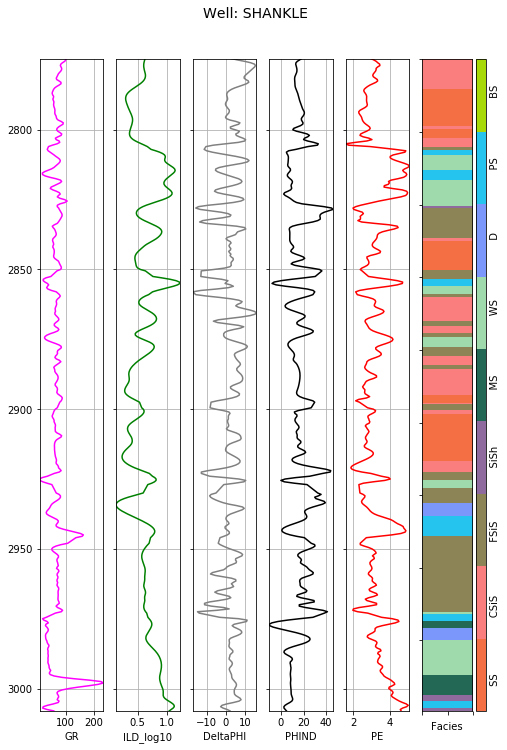

In [15]:
EMD_data = pd.read_csv('EMD_data01.csv', encoding = 'utf-8')
make_facies_log_plot(
    EMD_data[EMD_data['Well Name'] == 'SHANKLE'],
    facies_colors)

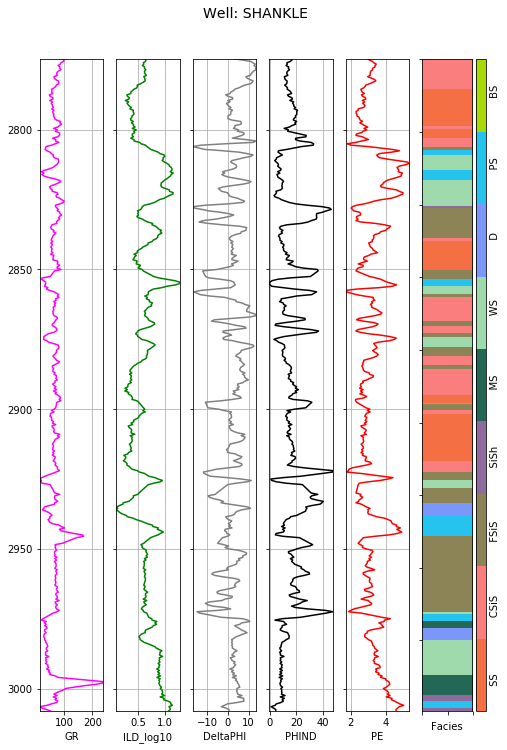

In [14]:
#data_ceemd.loc[:,'Label'] = data_ceemd.apply(lambda row: label_facies(row, facies_labels), axis=1)
EEMD_data = pd.read_csv('EEMD_data01.csv', encoding = 'utf-8')
make_facies_log_plot(
    EEMD_data[EEMD_data['Well Name'] == 'SHANKLE'],
    facies_colors)

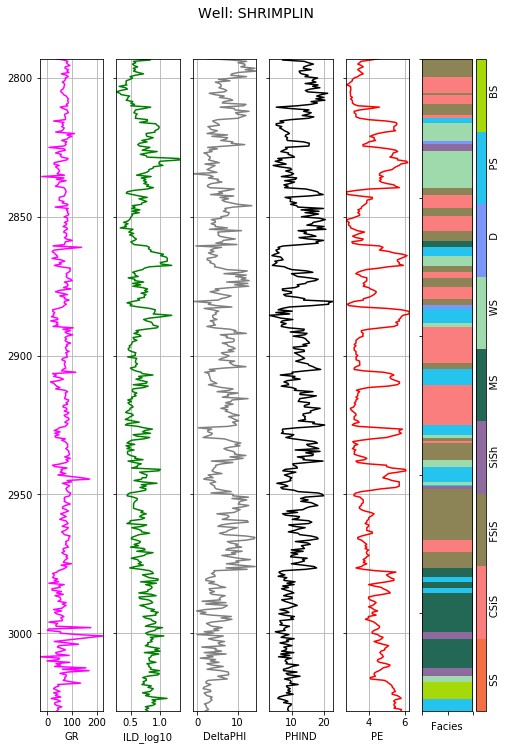

In [165]:
make_facies_log_plot(
    CEEMD_data[CEEMD_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

### <font color = "limegreen"> Feature engineering. Ранее данные были обработаны в 3 этапа, теперь нужно решить основную задачу мультиклассовой классификации. Для ее решения может быть полезным создание новых, дополнительных, признаков, которые помогут лучше классифицировать объекты -  фации. Создание дополнительных признаков  будет основано на знаниях из предметной области, точнее, на законе Вальтера (Э.Хэллем "Интерпретация фаций и стратиграфическая последовательность").
Из геологов XlX в. наиболее подробно обсуждал фациальные связи немецкий ученый Иогапнес Вальтер, известный как автор закона о соотношении фаций. Этот так называемый закон (или правило) Вальтера толковался по-разному, поэтому Миддлтои [324] попытался воспрепятствовать возможному смешению понятий, возвратясь к исходному определению, данному Вальтером, Миддлтон привел следующий отрывок из работы Вальтера, вышедшей в 1894 г. ([498], с, 979): 
«Различные отложения одной и той же фациальной области, как и совокупность пород разных фациальных областей, формируются рядом друг с другом в пространстве, хотя в разрезе мы видим их лежащими одни на других... Далеко идущее следствие такого утверждения состоит в том, что первично следуют друг за другом только те фации и фациальные области, которые в современных условиях наблюдаются рядом друг с другом».  </font>
https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D1%8F - вот здесь смотри законы литологии о периодичности и корреляции фаций.
https://www.bygeo.ru/materialy/chetvertyi_kurs/uchenie-o-faciyah-lukashev-chtenie/2160-tektonicheskie-dvizheniya.html
Циклическое чередование фаций 

### <font color = "blue"> Feature correlation  </font>

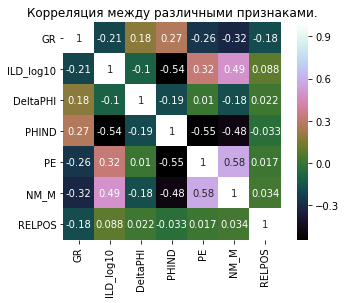

In [33]:
correlation = facies_data[features].fillna(facies_data.mean()).corr()
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Корреляция между различными признаками.')
plt.show()

In [34]:
facies_data[features].fillna(facies_data.mean()).corr()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
GR,1.000000,-0.205855,0.178863,0.270730,-0.259732,-0.316284,-0.182051
ILD_log10,-0.205855,1.000000,-0.104827,-0.544401,0.324841,0.493570,0.088227
DeltaPHI,0.178863,-0.104827,1.000000,-0.189350,0.010051,-0.177500,0.022470
PHIND,0.270730,-0.544401,-0.189350,1.000000,-0.546253,-0.481014,-0.033335
PE,-0.259732,0.324841,0.010051,-0.546253,1.000000,0.580339,0.016694
NM_M,-0.316284,0.493570,-0.177500,-0.481014,0.580339,1.000000,0.034015
RELPOS,-0.182051,0.088227,0.022470,-0.033335,0.016694,0.034015,1.000000


🎓 Посмотрим также,какие признаки являются наиболее важными [feature importance](https://habr.com/post/342366/), а значит, с ними мы должны обязательно поработать,чтобы сделать итоговую модель как можно более качественной.

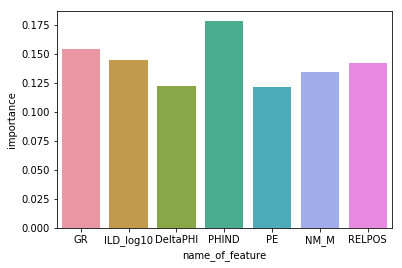

In [36]:
from sklearn.ensemble import RandomForestClassifier
facies = facies_data[['Facies','GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE','NM_M', 'RELPOS']].fillna(facies_data.mean())
model = RandomForestClassifier()
y,X = facies['Facies'],facies.drop('Facies',axis=1)
model.fit(X,y)
imp_f = pd.DataFrame({'name_of_feature':X.columns,'importance':model.feature_importances_})
sns.barplot(imp_f.name_of_feature,imp_f.importance)
plt.show()

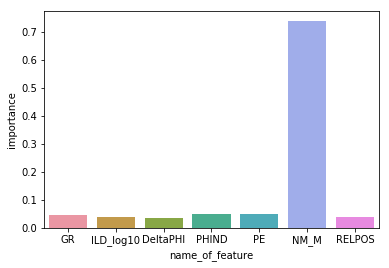

In [49]:
facies = facies_data[['Facies','GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE','NM_M', 'RELPOS']].fillna(facies_data.mean())
model = XGBClassifier(n_estimators = 150,max_depth = 7)
y,X = facies['Facies'],facies.drop('Facies',axis=1)
model.fit(X,y)
imp_f = pd.DataFrame({'name_of_feature':X.columns,'importance':model.feature_importances_})
sns.barplot(imp_f.name_of_feature,imp_f.importance)
plt.show()

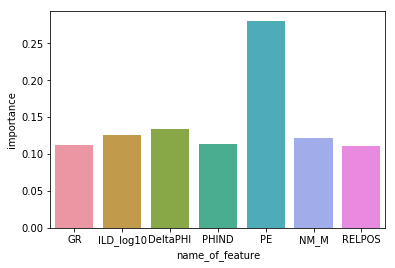

In [46]:
facies = good_data[['Facies','GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE','NM_M', 'RELPOS']]
model = XGBClassifier(n_estimators = 300,max_depth = 7)
y,X = facies['Facies'],facies.drop('Facies',axis=1)
model.fit(X,y)
imp_f = pd.DataFrame({'name_of_feature':X.columns,'importance':model.feature_importances_})
sns.barplot(imp_f.name_of_feature,imp_f.importance)
plt.show()

In [ ]:
# Feature engineering
#Наше предположение состоит в том, что фации не переходят из одного слоя глубины в другой. 
#Поэтому мы считаем признаки на соседних слоях коррелированными каким-то образом. 
#Чтобы возможно использовать этот факт, давайте выполним добавление признака с помощью:
#Агрегирование признаков на соседних глубинах.
#Вычисление пространственного градиента признака.

In [318]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

In [319]:
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

In [320]:
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [83]:
# Augment features
X = facies_data[features].fillna(facies_data.mean()).values
X_aug, padded_rows = augment_features(X, well, depth)

In [87]:
X_aug[1]

array([ 7.7450e+01,  6.6400e-01,  9.9000e+00,  1.1915e+01,  4.6000e+00,
        1.0000e+00,  1.0000e+00,  7.8260e+01,  6.6100e-01,  1.4200e+01,
        1.2565e+01,  4.1000e+00,  1.0000e+00,  9.7900e-01,  7.9050e+01,
        6.5800e-01,  1.4800e+01,  1.3050e+01,  3.6000e+00,  1.0000e+00,
        9.5700e-01,  1.5800e+00, -6.0000e-03,  1.2000e+00,  9.7000e-01,
       -1.0000e+00,  0.0000e+00, -4.4000e-02])

In [85]:
padded_rows

array([   0,  471,  698,  937, 1386, 1402, 1406, 1592, 1847, 2286, 2743,
       2787, 2893, 3202, 3282, 3514, 3745, 3784], dtype=int64)

In [88]:
X_aug.shape

(4149, 28)

In [321]:
X_pr = good_data[features].values
X_aug, padded_rows = augment_features(X_pr, well, depth)

In [322]:
X_aug[1]

array([ 0.82576837, -0.52261238, -1.63706274,  3.07492761, -6.55094078,
        1.        ,  0.018     ,  1.08963905, -0.41952558, -2.0791065 ,
        3.75203669, -5.13604987,  1.        ,  0.645     ,  1.35670932,
       -0.64218333, -1.87054567,  4.49444594, -4.63937483,  1.        ,
        0.939     ,  0.53414054, -0.4453155 ,  0.41712166,  1.48481851,
        0.99335008,  0.        ,  0.588     ])